In [ ]:
"""
Anomaly detection using Seasonal-Trend decomposition based on:
Lee, H. (2020). anomaly-detection-with-seasonal-trend-decomposition
GitHub: https://github.com/leeharry709/anomaly-detection-with-seasonal-trend-decomposition

Specific components adapted:
- STL decomposition for time series
- Residual analysis for anomaly detection
- Threshold calculation methods
"""

# Your anomaly detection implementation
from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn.ensemble import IsolationForest
from scipy.stats import median_abs_deviation
from statsmodels.tsa.seasonal import STL
from pathlib import Path
import scipy.stats as stats

class STLAnomalyDetector:
    def __init__(self,
                 seasonal_period: int = 52,
                 seasonal_window: int = 7,
                 trend_window: int = 53,
                 robust: bool = True,
                 n_methods_threshold: int = 2,
                 persistence_weeks: int = 2,
                
                 ZSCORE_THRESH: float = 2.5,
                 MAD_THRESH: float = 2.5,
                 IQR_MULTIPLIER: float = 1.5,
                 CUSUM_K: float = 0.3,
                 CUSUM_H: float = 3.5,
                 ISOLATION_CONTAMINATION: float = 0.1):
        self.seasonal_period = seasonal_period
        self.seasonal_window = seasonal_window if seasonal_window % 2 == 1 else seasonal_window + 1
        self.trend_window = trend_window if trend_window % 2 == 1 else trend_window + 1
        self.robust = robust
        self.n_methods_threshold = n_methods_threshold
        self.persistence_weeks = persistence_weeks

        # unified thresholds
        self.ZSCORE_THRESH = ZSCORE_THRESH
        self.MAD_THRESH = MAD_THRESH
        self.IQR_MULTIPLIER = IQR_MULTIPLIER
        self.CUSUM_K = CUSUM_K
        self.CUSUM_H = CUSUM_H
        self.ISOLATION_CONTAMINATION = ISOLATION_CONTAMINATION

    def decompose_stl(self, ts: pd.Series) -> Dict:
        if len(ts) < 2 * self.seasonal_period:
            raise ValueError(f"Time series too short: {len(ts)} < {2 * self.seasonal_period}")
        ts_resampled = self._resample_to_weekly(ts)
        ts_clean = ts_resampled.interpolate(method='time').fillna(method='bfill').fillna(method='ffill')
        stl = STL(ts_clean, period=self.seasonal_period, seasonal=self.seasonal_window,
                  trend=self.trend_window, robust=self.robust)
        result = stl.fit()
        fitted = result.trend + result.seasonal
        residuals = ts_clean - fitted
        # % error relative to fitted (avoid div by zero)
        fitted_nonzero = fitted.replace(0, np.nan)
        residual_pct_error = (residuals / fitted_nonzero) * 100
        residual_pct_error = residual_pct_error.fillna(0)
        return {
            'trend': result.trend,
            'seasonal': result.seasonal,
            'residuals': residuals,
            'fitted': fitted,
            'residual_pct_error': residual_pct_error,
            'original_resampled': ts_resampled
        }

    def _resample_to_weekly(self, ts: pd.Series) -> pd.Series:
        if not isinstance(ts.index, pd.DatetimeIndex):
            ts.index = pd.to_datetime(ts.index)
        ts = ts.sort_index()
        ts = ts[~ts.index.duplicated(keep='first')]
        start_date, end_date = ts.index.min(), ts.index.max()
        weekly_dates = pd.date_range(start=start_date, end=end_date, freq='W-SUN')
        if len(weekly_dates) < 2 * self.seasonal_period:
            weekly_start = start_date - pd.Timedelta(days=start_date.weekday())
            weekly_end = end_date + pd.Timedelta(days=6-end_date.weekday())
            weekly_dates = pd.date_range(start=weekly_start, end=weekly_end, freq='W-SUN')
        # reindex with nearest tolerance so we keep original weeks when possible
        ts_weekly = ts.reindex(weekly_dates, method='nearest', tolerance=pd.Timedelta(days=4))
        ts_weekly = ts_weekly.interpolate(method='time').fillna(method='bfill').fillna(method='ffill')
        return ts_weekly

    # unified detectors using same thresholds as Prophet pipeline
    def detect_zscore_anomalies(self, residuals: pd.Series, baseline_std: float = None):
        if baseline_std is None or baseline_std <= 0:
            baseline_std = residuals.std(ddof=1) if residuals.std(ddof=1) > 1e-8 else 1.0
        z_scores = np.abs(residuals / baseline_std)
        return (z_scores > self.ZSCORE_THRESH).astype(int)

    def detect_mad_anomalies(self, residuals: pd.Series, baseline_mad: float = None):
        if baseline_mad is None or baseline_mad <= 0:
            baseline_mad = median_abs_deviation(residuals, scale=1.0)
            baseline_mad = baseline_mad if baseline_mad > 1e-8 else (residuals.std() if residuals.std() > 1e-8 else 1.0)
        mz = 0.6745 * np.abs(residuals - np.median(residuals)) / baseline_mad
        return (mz > self.MAD_THRESH).astype(int)

    def detect_iqr_anomalies(self, residuals: pd.Series):
        q75, q25 = np.percentile(residuals.fillna(0), [75, 25])
        iqr = max(q75 - q25, 1e-8)
        lower = q25 - self.IQR_MULTIPLIER * iqr
        upper = q75 + self.IQR_MULTIPLIER * iqr
        return ((residuals < lower) | (residuals > upper)).astype(int)

    def detect_isolation_forest_anomalies(self, residuals: pd.Series, contamination: float = None):
        if contamination is None:
            contamination = self.ISOLATION_CONTAMINATION
        if len(residuals) < 10:
            return pd.Series(0, index=residuals.index)
        X = residuals.values.reshape(-1, 1)
        iso = IsolationForest(contamination=contamination, random_state=42)
        preds = iso.fit_predict(X)
        return pd.Series((preds == -1).astype(int), index=residuals.index)

    def detect_cusum_anomalies(self, residuals: pd.Series):
        # Use same k/h multipliers as Prophet implementation but operate on resid (not resid_pct)
        sigma = residuals.std(ddof=1) if residuals.std(ddof=1) > 1e-8 else 1.0
        k = self.CUSUM_K * sigma
        h = self.CUSUM_H * sigma
        Spos = np.zeros(len(residuals))
        Sneg = np.zeros(len(residuals))
        flags = np.zeros(len(residuals), dtype=int)
        resid = residuals.fillna(0).to_numpy()
        for i in range(1, len(resid)):
            Spos[i] = max(0.0, Spos[i-1] + resid[i] - k)
            Sneg[i] = min(0.0, Sneg[i-1] + resid[i] + k)
            if Spos[i] > h or Sneg[i] < -h:
                flags[i] = 1
                Spos[i] = 0.0
                Sneg[i] = 0.0
        return pd.Series(flags, index=residuals.index)

    def apply_ensemble_voting(self, methods_dict: Dict[str, pd.Series]):
        votes = pd.DataFrame(methods_dict).sum(axis=1)
        return (votes >= self.n_methods_threshold).astype(int)

    def apply_persistence_filter_with_weeks(self, anomalies: pd.Series, persistence_weeks: int):
        filtered = anomalies.copy()
        groups = (anomalies != anomalies.shift()).cumsum()
        for gid in groups.unique():
            mask = groups == gid
            vals = anomalies[mask]
            if vals.iloc[0] == 1 and len(vals) < persistence_weeks:
                filtered[mask] = 0
        return filtered

    def classify_regimes(self, dates: pd.Series) -> pd.Series:
        regimes = pd.Series('unknown', index=dates.index)
        for idx, date in dates.items():
            if pd.isna(date):
                continue
            yr = pd.to_datetime(date).year
            if yr <= 2019:
                regimes[idx] = 'pre_pandemic'
            elif yr in [2020, 2021]:
                regimes[idx] = 'pandemic'
            elif yr >= 2022:
                regimes[idx] = 'post_pandemic'
        return regimes

    def build_event_ground_truth(self, events_series):
        if events_series is None:
            return None
        keywords = [
            "COVID", "Covid", "coronavirus", "lockdown", "pandemic",
            "Suez", "canal", "blocking", "stuck",
            "HGV", "driver", "shortage", "logistics",
            "Strike", "Rail", "transport", "disruption",
            "Port", "shipping", "container", "supply chain",
            "Brexit", "customs", "border",
            "weather", "storm", "flooding", "snow",
            "fuel", "energy", "crisis", "shortage"
        ]
        def has_event(text):
            if pd.isna(text) or text == "":
                return False
            t = str(text).lower()
            return any(k.lower() in t for k in keywords)
        return events_series.fillna("").apply(has_event).astype(int)

    def detect_anomalies_single_product(self, product_data: pd.DataFrame, product_id: int):
        # prepare
        product = product_data.copy()
        product['week_start_date'] = pd.to_datetime(product['week_start_date'])
        product = product.sort_values('week_start_date').drop_duplicates(subset=['week_start_date'])
        ts = product.set_index('week_start_date')['demand_units']
        print(f"Processing product {product_id}: {len(ts)} obs | {ts.index.min()} to {ts.index.max()}")

        # STL decompose
        try:
            stl_res = self.decompose_stl(ts)
        except Exception as e:
            print(f"  STL failed: {e}")
            return pd.DataFrame()

        ts_resampled = stl_res['original_resampled']
        residuals = stl_res['residuals']
        resid_pct = stl_res['residual_pct_error']

        # regimes
        regimes = self.classify_regimes(pd.Series(ts_resampled.index, index=ts_resampled.index))
        pre_mask = regimes == 'pre_pandemic'
        post_mask = regimes.isin(['pandemic', 'post_pandemic'])

        # baseline calibration from pre-pandemic resid_pct (mirrors Prophet)
        pre_vals = resid_pct[pre_mask].to_numpy()
        eps = 1e-8
        baseline_std = max(pre_vals.std(ddof=1) if len(pre_vals)>1 else 0.0, eps)
        baseline_mad = max(median_abs_deviation(pre_vals, scale=1.0) if len(pre_vals)>0 else 0.0, eps)
        q75, q25 = np.percentile(pre_vals if len(pre_vals)>0 else resid_pct.fillna(0), [75, 25])
        iqr = max(q75 - q25, eps)

        # apply detectors (same methods as Prophet)
        methods = {}
        methods['zscore'] = self.detect_zscore_anomalies(resid_pct, baseline_std)
        methods['mad'] = self.detect_mad_anomalies(resid_pct, baseline_mad)
        methods['iqr'] = self.detect_iqr_anomalies(resid_pct)
        # isolation: calibrate contamination based on pre-pandemic outlier rate like in Prophet
        pre_abs = np.abs(pre_vals) if len(pre_vals)>0 else np.abs(resid_pct.fillna(0))
        target_fpr = 0.01
        thr = np.quantile(pre_abs, 1 - target_fpr) if len(pre_abs)>0 else 0.0
        auto_contam = float(np.clip((pre_abs > thr).mean() if len(pre_abs)>0 else self.ISOLATION_CONTAMINATION,
                                    0.003, 0.03))
        methods['isolation'] = self.detect_isolation_forest_anomalies(resid_pct, contamination=auto_contam)
        methods['cusum'] = self.detect_cusum_anomalies(residuals)

        # changepoint using ruptures (optional — keep parity with Prophet)
        try:
            algo = rpt.Pelt(model="rbf").fit(resid_pct.fillna(0).to_numpy())
            cps = algo.predict(pen=10)
            cp_flag = np.zeros(len(resid_pct), dtype=int)
            for cp in cps[:-1]:
                start = max(0, cp - 2); end = min(len(resid_pct), cp + 3)
                cp_flag[start:end] = 1
            methods['changepoint'] = pd.Series(cp_flag, index=resid_pct.index)
        except Exception:
            methods['changepoint'] = pd.Series(0, index=resid_pct.index)

        # voting + persistence (apply same thresholds)
        ensemble = self.apply_ensemble_voting(methods)
        final = pd.Series(0, index=ensemble.index)
        # persistence rules: pre-pandemic 3 weeks, post 2 weeks (like your STL)
        final[pre_mask] = self.apply_persistence_filter_with_weeks(ensemble[pre_mask], persistence_weeks=3)
        final[post_mask] = self.apply_persistence_filter_with_weeks(ensemble[post_mask], persistence_weeks=2)

        # Prepare results df
        out = pd.DataFrame({
            'week_start_date': ts_resampled.index,
            'product_id': product_id,
            'demand_units': ts_resampled.values,
            'trend': stl_res['trend'].values,
            'seasonal': stl_res['seasonal'].values,
            'residuals': stl_res['residuals'].values,
            'fitted': stl_res['fitted'].values,
            'residual_pct_error': stl_res['residual_pct_error'].values,
            'regime': regimes.values,
            **{f'anomaly_{k}': v.values if hasattr(v, 'values') else v for k, v in methods.items()},
            'anomaly_ensemble': ensemble.values,
            'anomaly_final': final.values
        })

        # attach original event column if exists (match by date)
        if 'event' in product.columns:
            ev = product.set_index('week_start_date')['event']
            out = out.merge(ev.rename('event'), left_on='week_start_date', right_index=True, how='left')

        print(f"  Resampled {len(ts_resampled)} weeks, final anomalies: {out['anomaly_final'].sum()}")
        return out

# === Модификация main runner с оценкой F1 на продукт ===
def run_stl_anomaly_detection_all_products_with_eval(dataset_path: str, output_dir: str = "stl_output"):
    Path(output_dir).mkdir(exist_ok=True)
    df = pd.read_csv(dataset_path)
    df['week_start_date'] = pd.to_datetime(df['week_start_date'])
    product_ids = sorted(df['product_id'].unique())

    detector = STLAnomalyDetector(
        seasonal_period=52,
        trend_window=53,
        robust=True,
        n_methods_threshold=2,
        persistence_weeks=2,
        # match prophet hyperparams:
        ZSCORE_THRESH=2.5,
        MAD_THRESH=2.5,
        IQR_MULTIPLIER=1.5,
        CUSUM_K=0.3,
        CUSUM_H=3.5,
        ISOLATION_CONTAMINATION=0.1
    )

    all_results = []
    eval_rows = []

    for pid in product_ids:
        product_df = df[df['product_id'] == pid].copy()
        if len(product_df) < 104:
            print(f"Skipping product {pid}: insufficient data ({len(product_df)})")
            continue
        res = detector.detect_anomalies_single_product(product_df, pid)
        if res.empty:
            continue
        # Save per-product CSV
        out_path = Path(output_dir) / f"product_{pid:02d}_stl.csv"
        res.to_csv(out_path, index=False)
        all_results.append(res)

        # If event column exists, compute PRF1
        if 'event' in res.columns:
            y_true = detector.build_event_ground_truth(res['event'])
            if y_true is None or y_true.sum() == 0:
                print(f"  Product {pid}: no events -> skipping eval")
                eval_rows.append({'product_id': pid, 'precision': np.nan, 'recall': np.nan, 'f1': np.nan, 'detected': int(res['anomaly_final'].sum())})
            else:
                y_pred = res['anomaly_final'].fillna(0).astype(int).values
                pr, rc, f1, _ = precision_recall_fscore_support(y_true.values, y_pred, average='binary', zero_division=0)
                eval_rows.append({'product_id': pid, 'precision': pr, 'recall': rc, 'f1': f1, 'detected': int(y_pred.sum())})
                print(f"  Eval Product {pid}: P={pr:.3f} R={rc:.3f} F1={f1:.3f} Detected={y_pred.sum()}")
        else:
            eval_rows.append({'product_id': pid, 'precision': np.nan, 'recall': np.nan, 'f1': np.nan, 'detected': int(res['anomaly_final'].sum())})

    # combine and save summary
    if all_results:
        combined = pd.concat(all_results, ignore_index=True)
        combined.to_csv(Path(output_dir) / "all_products_stl_anomalies.csv", index=False)

    eval_df = pd.DataFrame(eval_rows)
    eval_df.to_csv(Path(output_dir) / "stl_evaluation_by_product.csv", index=False)
    print(f"Saved evaluation: {Path(output_dir) / 'stl_evaluation_by_product.csv'}")
    return combined if all_results else None, eval_df

# === Usage ===
# combined_df, eval_df = run_stl_anomaly_detection_all_products_with_eval(DATASET_PATH, OUTPUT_DIR)


In [ ]:
"""
Anomaly detection using Seasonal-Trend decomposition based on:
Lee, H. (2020). anomaly-detection-with-seasonal-trend-decomposition
GitHub: https://github.com/leeharry709/anomaly-detection-with-seasonal-trend-decomposition

Specific components adapted:
- STL decomposition for time series
- Residual analysis for anomaly detection
- Threshold calculation methods
"""

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class STLCombinedAnomalyDetector:
    def __init__(self, dataset_path, product_id=None, aggregate_all=True):
        self.dataset_path = dataset_path
        self.product_id = product_id
        self.aggregate_all = aggregate_all
        self.df = None
        self.stl_results = {}
        self.forecasts = {}   #
        self.residuals = {}
        self.anomalies = {}
        self.regressor_cols = []
        self.evaluation_metrics = {}

        self.regimes = {
            'pre_pandemic': {'start': '2016-01-03', 'end': '2019-12-29'},
            'pandemic': {'start': '2020-01-05', 'end': '2021-12-26'},
            'post_pandemic': {'start': '2022-01-02', 'end': '2024-12-29'}
        }

        self.ZSCORE_THRESH = 2.5
        self.MAD_THRESH = 2.5
        self.IQR_MULTIPLIER = 1.5
        self.CUSUM_K = 0.3
        self.CUSUM_H = 3.5
        self.ISOLATION_CONTAMINATION = 0.1

    # load & prep
    def load_and_prepare_data(self):
        self.df = pd.read_csv(self.dataset_path)
        # ensure date col exists and convert
        if 'week_start_date' not in self.df.columns:
            raise ValueError("CSV must contain 'week_start_date' column")
        self.df['week_start_date'] = pd.to_datetime(self.df['week_start_date'], errors='coerce')
        self.df = self.df.sort_values('week_start_date')

        if self.product_id is not None:
            print(f"Filtering data for Product {self.product_id}...")
            product_data = self.df[self.df['product_id'] == self.product_id].copy()
            if len(product_data) == 0:
                available_products = sorted(self.df['product_id'].unique())
                raise ValueError(f"Product {self.product_id} not found. Available: {available_products}")
            product_data = product_data.rename(columns={'week_start_date': 'ds', 'demand_units': 'y'})
            self.df = product_data
            print(f"Product {self.product_id} data: {len(product_data)} records")

        elif self.aggregate_all:
            numeric_cols = ['demand_units', 'supplier_distance_km',
                            'estimated_lead_time_days', 'actual_lead_time_days', 'delay_days',
                            'traffic_congestion_level', 'weather_severity', 'port_congestion_level',
                            'customs_processing_days', 'warehouse_inventory_units']

            existing_numeric_cols = [col for col in numeric_cols if col in self.df.columns]
            agg_dict = {}
            for col in existing_numeric_cols:
                if col in ['demand_units', 'order_volume', 'warehouse_inventory_units']:
                    agg_dict[col] = 'sum'
                else:
                    agg_dict[col] = 'mean'

            agg_data = self.df.groupby('week_start_date').agg(agg_dict).reset_index()
            agg_data = agg_data.rename(columns={'week_start_date': 'ds', 'demand_units': 'y'})
            self.df = agg_data

        self.df = self.df.sort_values('ds').reset_index(drop=True)
        self._aggregate_week_duplicates()
        return self.df

    def _aggregate_week_duplicates(self):
        if 'ds' not in self.df.columns:
            return
        if not self.df['ds'].duplicated().any():
            print(f"Duplicate rows: 0")
            return
        num_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()
        nonnum_cols = [c for c in self.df.columns if c not in (['ds'] + num_cols)]
        sum_candidates = ['y', 'order_volume', 'warehouse_inventory_units']
        sum_cols = [c for c in sum_candidates if c in num_cols]
        other_num_cols = [c for c in num_cols if c not in (sum_cols + ['product_id'])]
        cat_cols = [c for c in nonnum_cols if c != 'ds']

        agg = {}
        agg.update({c: 'sum' for c in sum_cols})
        agg.update({c: 'mean' for c in other_num_cols})
        if 'product_id' in self.df.columns:
            agg['product_id'] = 'first'
        agg.update({c: 'first' for c in cat_cols})

        self.df = (self.df.groupby('ds', as_index=False).agg(agg)
                   .sort_values('ds').reset_index(drop=True))

    
    def define_regime_masks(self, base_df=None):
        df_ = self.df if base_df is None else base_df
        masks = {}
        for regime, dates in self.regimes.items():
            mask = (df_['ds'] >= dates['start']) & (df_['ds'] <= dates['end'])
            masks[regime] = mask
            print(f"{regime}: {mask.sum()} records ({dates['start']} to {dates['end']})")
        return masks


    def fit_stl_and_build_fitted(self):
        df_local = self.df.copy()
        df_local = df_local.rename(columns={'ds': 'ds', 'y': 'y'})
        df_local = df_local.set_index('ds').sort_index()
        # resample weekly 
        ts = df_local['y'].resample('W-SUN').mean().interpolate().ffill().bfill()

        stl = STL(ts, period=52, robust=True)
        res = stl.fit()
        fitted = (res.trend + res.seasonal).rename('yhat')
        forecast_df = pd.DataFrame({'ds': fitted.index, 'yhat': fitted.values}).merge(
            df_local.reset_index()[['ds', 'y']], on='ds', how='left')
        if 'event' in self.df.columns:
            ev = self.df[['ds', 'event']].drop_duplicates(subset=['ds'])
            forecast_df = forecast_df.merge(ev, on='ds', how='left')
        self.stl_results['stl_obj'] = res
        self.forecasts['all'] = forecast_df
        return forecast_df

    # residuals
    def compute_residuals(self):
        forecast = self.forecasts['all'].copy()
        forecast['residuals'] = forecast['y'] - forecast['yhat']
        forecast['abs_residuals'] = np.abs(forecast['residuals'])
        forecast['squared_residuals'] = forecast['residuals'] ** 2
        eps = 1e-6
        forecast['resid_pct'] = 100.0 * forecast['residuals'] / (np.abs(forecast['yhat']) + eps)
        forecast['abs_resid_pct'] = np.abs(forecast['resid_pct'])
        # split into regimes
        masks = self.define_regime_masks(base_df=forecast)
        for regime, mask in masks.items():
            df_reg = forecast.loc[mask].reset_index(drop=True)
            mae = df_reg['abs_residuals'].mean()
            rmse = np.sqrt((df_reg['squared_residuals']).mean())
            maep = df_reg['abs_resid_pct'].mean()
            print(f"{regime} residuals - MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAE%: {maep:.2f}%")
            self.residuals[regime] = df_reg
        return self.residuals

    # detection
    def detect_anomalies_multiple_methods(self):
        pre = self.residuals['pre_pandemic']['resid_pct'].to_numpy()
        eps = 1e-8
        baseline_std = max(pre.std(ddof=1), eps)
        baseline_mad = max(median_abs_deviation(pre, scale=1.0), eps)
        q75, q25 = np.percentile(pre, [75, 25])
        iqr = max(q75 - q25, eps)

        target_fpr = 0.01
        pre_abs = np.abs(pre)
        thr = np.quantile(pre_abs, 1 - target_fpr)
        auto_contam = float(np.clip((pre_abs > thr).mean(), 0.003, 0.03))

        for regime, residuals_df in self.residuals.items():
            anomaly_df = residuals_df.copy()
            resid_pct = anomaly_df['resid_pct'].to_numpy()

            # 1. Z-score 
            z_scores = np.abs(resid_pct / baseline_std)
            anomaly_df['anomaly_zscore'] = (z_scores > self.ZSCORE_THRESH).astype(int)

            # 2. MAD
            mz = 0.6745 * np.abs(resid_pct - np.median(resid_pct)) / baseline_mad
            anomaly_df['anomaly_mad'] = (mz > self.MAD_THRESH).astype(int)

            # 3. IQR
            anomaly_df['anomaly_iqr'] = (
                ((resid_pct < (q25 - self.IQR_MULTIPLIER * iqr)) |
                 (resid_pct > (q75 + self.IQR_MULTIPLIER * iqr)))
            ).astype(int)

            # 4. Isolation Forest
            iso_forest = IsolationForest(contamination=auto_contam, random_state=42)
            try:
                iso_pred = iso_forest.fit_predict(resid_pct.reshape(-1, 1))
                anomaly_df['anomaly_isolation'] = (iso_pred == -1).astype(int)
            except Exception:
                anomaly_df['anomaly_isolation'] = 0

            # 5. CUSUM (use same implementation)
            anomaly_df['anomaly_cusum'] = self._cusum_detection(anomaly_df['residuals'].to_numpy(), baseline_std)

            # 6. Changepoint
            try:
                algo = rpt.Pelt(model="rbf").fit(resid_pct)
                changepoints = algo.predict(pen=10)
                cp_flag = np.zeros(len(resid_pct), dtype=bool)
                for cp in changepoints[:-1]:
                    start_idx = max(0, cp - 2)
                    end_idx = min(len(resid_pct), cp + 3)
                    cp_flag[start_idx:end_idx] = True
                anomaly_df['anomaly_changepoint'] = cp_flag.astype(int)
            except Exception:
                anomaly_df['anomaly_changepoint'] = 0

            method_cols = ['anomaly_zscore', 'anomaly_mad', 'anomaly_iqr',
                           'anomaly_isolation', 'anomaly_cusum', 'anomaly_changepoint']
            anomaly_df['vote_count'] = anomaly_df[method_cols].sum(axis=1)
            anomaly_df['anomaly_ensemble'] = (anomaly_df['vote_count'] >= 2).astype(int)
            anomaly_df['anomaly_any'] = (anomaly_df['vote_count'] >= 1).astype(int)
            anomaly_df['anomaly_strict'] = (anomaly_df['vote_count'] >= 3).astype(int)

            self.anomalies[regime] = anomaly_df

        return self.anomalies

    def _cusum_detection(self, resid, sigma):
        if not sigma or sigma <= 1e-8:
            return np.zeros(len(resid), dtype=int)
        k = self.CUSUM_K * sigma
        h = self.CUSUM_H * sigma
        Spos = np.zeros_like(resid, dtype=float)
        Sneg = np.zeros_like(resid, dtype=float)
        flags = np.zeros_like(resid, dtype=int)
        for i in range(1, len(resid)):
            Spos[i] = max(0.0, Spos[i-1] + resid[i] - k)
            Sneg[i] = min(0.0, Sneg[i-1] + resid[i] + k)
            if Spos[i] > h or Sneg[i] < -h:
                flags[i] = 1
                Spos[i] = 0.0
                Sneg[i] = 0.0
        return flags

    # evaluation
    def build_event_ground_truth(self, events_series):
        if events_series is None:
            return None
        keywords = [
            "COVID", "Covid", "coronavirus", "lockdown", "pandemic",
            "Suez", "canal", "blocking", "stuck",
            "HGV", "driver", "shortage", "logistics",
            "Strike", "Rail", "transport", "disruption",
            "Port", "shipping", "container", "supply chain",
            "Brexit", "customs", "border",
            "weather", "storm", "flooding", "snow",
            "fuel", "energy", "crisis", "shortage"
        ]
        def has_event(text):
            if pd.isna(text) or text == "":
                return False
            text_lower = str(text).lower()
            return any(keyword.lower() in text_lower for keyword in keywords)
        return events_series.fillna("").apply(has_event).astype(int)

    def evaluate_with_events(self):
        all_data = pd.concat([df for df in self.anomalies.values()], ignore_index=True)
        all_data = all_data.sort_values('ds').reset_index(drop=True)

        if 'event' not in all_data.columns:
            print("No event column found - skipping event-based evaluation")
            return None

        y_true = self.build_event_ground_truth(all_data['event'])
        if y_true is None or y_true.sum() == 0:
            print("No events found in dataset")
            return None

        print(f"\nGround truth events: {y_true.sum()} out of {len(y_true)} periods ({y_true.sum()/len(y_true)*100:.1f}%)")
        print("\nEvaluating detection strategies:")

        strategies = {
            'ensemble': 'anomaly_ensemble',
            'any_method': 'anomaly_any',
            'strict': 'anomaly_strict'
        }

        for strategy_name, col_name in strategies.items():
            if col_name in all_data.columns:
                y_pred = all_data[col_name].fillna(0).astype(int).values
                detected = int(y_pred.sum())
                pr, rc, f1, _ = precision_recall_fscore_support(y_true.values, y_pred, average="binary", zero_division=0)
                self.evaluation_metrics[strategy_name] = {
                    'precision': pr, 'recall': rc, 'f1': f1, 'detected': detected
                }
                print(f"{strategy_name:12}: Detected={detected:3d} | P={pr:.3f} R={rc:.3f} F1={f1:.3f}")

        if self.evaluation_metrics:
            best_strategy = max(self.evaluation_metrics.keys(), key=lambda k: self.evaluation_metrics[k]['f1'])
            print(f"\nBest strategy: {best_strategy} (F1={self.evaluation_metrics[best_strategy]['f1']:.3f})")
            best_col = {'ensemble':'anomaly_ensemble','any_method':'anomaly_any','strict':'anomaly_strict'}[best_strategy]
            y_pred_best = all_data[best_col].fillna(0).astype(int).values
            print(f"\nClassification Report ({best_strategy}):")
            print(classification_report(y_true.values, y_pred_best, target_names=['Normal', 'Anomaly']))

        return self.evaluation_metrics

    # summary
    def generate_summary_report(self):
        masks = self.define_regime_masks()
        for regime, mask in masks.items():
            regime_data = self.df[mask]
            print(f"\n{regime.replace('_', ' ').title()}:")
            if len(regime_data) > 0:
                print(f"  Records: {mask.sum()}")
                print(f"  Date range: {regime_data['ds'].min()} to {regime_data['ds'].max()}")
                print(f"  Mean demand: {regime_data['y'].mean():.2f}")
                print(f"  Std demand: {regime_data['y'].std():.2f}")

        print("\nResidual Statistics:")
        for regime, residuals_df in self.residuals.items():
            residuals = residuals_df['residuals']
            mae = np.abs(residuals).mean()
            rmse = np.sqrt((residuals**2).mean())
            maep = residuals_df['abs_resid_pct'].mean()
            print(f"\n{regime.replace('_', ' ').title()}:")
            print(f"  MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAE%: {maep:.2f}%")

        print("\nAnomaly Detection Summary:")
        for regime, anomaly_df in self.anomalies.items():
            ensemble_count = int(anomaly_df['anomaly_ensemble'].sum())
            any_count = int(anomaly_df['anomaly_any'].sum())
            print(f"\n{regime.replace('_', ' ').title()}:")
            print(f"  Ensemble: {ensemble_count} ({ensemble_count/len(anomaly_df)*100:.1f}%)")
            print(f"  Any method: {any_count} ({any_count/len(anomaly_df)*100:.1f}%)")

    # run
    def run_complete_analysis(self):
        self.load_and_prepare_data()
        self.fit_stl_and_build_fitted()
        self.compute_residuals()
        self.detect_anomalies_multiple_methods()
        self.evaluate_with_events()
        self.generate_summary_report()
        return {
            'data': self.df,
            'stl_obj': self.stl_results.get('stl_obj'),
            'forecasts': self.forecasts,
            'residuals': self.residuals,
            'anomalies': self.anomalies,
            'evaluation_metrics': self.evaluation_metrics
        }

# main run
if __name__ == "__main__":
    detector = STLCombinedAnomalyDetector(
        dataset_path='UK20162023_modified.csv',
        product_id=1
    )
    results = detector.run_complete_analysis()

    print(f"STL: {results['stl_obj'] is not None}")
    print(f"Regimes: {len(results['residuals'])}")
    if results['evaluation_metrics']:
        best = max(results['evaluation_metrics'].items(), key=lambda x: x[1]['f1'])
        print(f"Best F1-score: {best[1]['f1']:.3f} ({best[0]} strategy)")


Filtering data for Product 1...
Product 1 data: 1148 records
pre_pandemic: 209 records (2016-01-03 to 2019-12-29)
pandemic: 104 records (2020-01-05 to 2021-12-26)
post_pandemic: 157 records (2022-01-02 to 2024-12-29)
pre_pandemic residuals - MAE: 36.16, RMSE: 64.43, MAE%: 34.31%
pandemic residuals - MAE: 42.81, RMSE: 71.97, MAE%: 38.61%
post_pandemic residuals - MAE: 36.54, RMSE: 80.59, MAE%: 33.22%

Ground truth events: 102 out of 470 periods (21.7%)

Evaluating detection strategies:
ensemble    : Detected= 26 | P=0.231 R=0.059 F1=0.094
any_method  : Detected= 47 | P=0.191 R=0.088 F1=0.121
strict      : Detected= 18 | P=0.167 R=0.029 F1=0.050

Best strategy: any_method (F1=0.121)

Classification Report (any_method):
              precision    recall  f1-score   support

      Normal       0.78      0.90      0.83       368
     Anomaly       0.19      0.09      0.12       102

    accuracy                           0.72       470
   macro avg       0.49      0.49      0.48       470
w

In [6]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn.linear_model import LinearRegression
from scipy.stats import median_abs_deviation
import ruptures as rpt

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class STLCombinedAnomalyDetector:
    def __init__(self, dataset_path, product_id=None, aggregate_all=True):
        self.dataset_path = dataset_path
        self.product_id = product_id
        self.aggregate_all = aggregate_all
        self.df = None
        self.stl_results = {}
        self.forecasts = {}
        self.residuals = {}
        self.anomalies = {}
        self.regressor_cols = []
        self.evaluation_metrics = {}

        self.regimes = {
            'pre_pandemic': {'start': '2016-01-03', 'end': '2019-12-29'},
            'pandemic': {'start': '2020-01-05', 'end': '2021-12-26'},
            'post_pandemic': {'start': '2022-01-02', 'end': '2024-12-29'}
        }

        self.ZSCORE_THRESH = 2.5
        self.MAD_THRESH = 2.5
        self.IQR_MULTIPLIER = 1.5
        self.CUSUM_K = 0.3
        self.CUSUM_H = 3.5
        self.ISOLATION_CONTAMINATION = 0.1

    def load_and_prepare_data(self):
        self.df = pd.read_csv(self.dataset_path)
        if 'week_start_date' not in self.df.columns:
            raise ValueError("CSV must contain 'week_start_date' column")
        self.df['week_start_date'] = pd.to_datetime(self.df['week_start_date'], errors='coerce')
        self.df = self.df.sort_values('week_start_date')

        if self.product_id is not None:
            print(f"Filtering data for Product {self.product_id}...")
            product_data = self.df[self.df['product_id'] == self.product_id].copy()
            if len(product_data) == 0:
                available_products = sorted(self.df['product_id'].unique())
                raise ValueError(f"Product {self.product_id} not found. Available: {available_products}")
            product_data = product_data.rename(columns={'week_start_date': 'ds', 'demand_units': 'y'})
            self.df = product_data
            print(f"Product {self.product_id} data: {len(product_data)} records")
        elif self.aggregate_all:
            numeric_cols = ['demand_units', 'supplier_distance_km',
                            'estimated_lead_time_days', 'actual_lead_time_days', 'delay_days',
                            'traffic_congestion_level', 'weather_severity', 'port_congestion_level',
                            'customs_processing_days', 'warehouse_inventory_units']

            existing_numeric_cols = [col for col in numeric_cols if col in self.df.columns]
            agg_dict = {}
            for col in existing_numeric_cols:
                if col in ['demand_units', 'order_volume', 'warehouse_inventory_units']:
                    agg_dict[col] = 'sum'
                else:
                    agg_dict[col] = 'mean'

            agg_data = self.df.groupby('week_start_date').agg(agg_dict).reset_index()
            agg_data = agg_data.rename(columns={'week_start_date': 'ds', 'demand_units': 'y'})
            self.df = agg_data

        self.df = self.df.sort_values('ds').reset_index(drop=True)
        self._aggregate_week_duplicates()
        return self.df

    def _aggregate_week_duplicates(self):
        if 'ds' not in self.df.columns:
            return
        if not self.df['ds'].duplicated().any():
            print(f"Duplicate rows: 0")
            return
        num_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()
        nonnum_cols = [c for c in self.df.columns if c not in (['ds'] + num_cols)]
        sum_candidates = ['y', 'order_volume', 'warehouse_inventory_units']
        sum_cols = [c for c in sum_candidates if c in num_cols]
        other_num_cols = [c for c in num_cols if c not in (sum_cols + ['product_id'])]
        cat_cols = [c for c in nonnum_cols if c != 'ds']

        agg = {}
        agg.update({c: 'sum' for c in sum_cols})
        agg.update({c: 'mean' for c in other_num_cols})
        if 'product_id' in self.df.columns:
            agg['product_id'] = 'first'
        agg.update({c: 'first' for c in cat_cols})

        self.df = (self.df.groupby('ds', as_index=False).agg(agg)
                   .sort_values('ds').reset_index(drop=True))

    def define_regime_masks(self, base_df=None):
        df_ = self.df if base_df is None else base_df
        masks = {}
        for regime, dates in self.regimes.items():
            mask = (df_['ds'] >= dates['start']) & (df_['ds'] <= dates['end'])
            masks[regime] = mask
            print(f"{regime}: {mask.sum()} records ({dates['start']} to {dates['end']})")
        return masks

    def fit_stl_and_build_fitted(self):
        # Create continuous weekly index
        df_idx = self.df.set_index('ds').sort_index()
        full_index = pd.date_range(start=df_idx.index.min(), end=df_idx.index.max(), freq='W-SUN')
        ts_full = df_idx['y'].reindex(full_index)

        # Get pre-pandemic period
        pre_start = pd.to_datetime(self.regimes['pre_pandemic']['start'])
        pre_end = pd.to_datetime(self.regimes['pre_pandemic']['end'])
        pre_mask = (full_index >= pre_start) & (full_index <= pre_end)
        ts_pre = ts_full.loc[pre_mask]

        # Light filling only
        ts_pre_filled = ts_pre.fillna(method='ffill', limit=2).fillna(method='bfill', limit=2)
        
        # Remove any remaining NaNs by interpolation
        if ts_pre_filled.isna().any():
            ts_pre_filled = ts_pre_filled.interpolate(method='linear')
        
        # Box-Cox-like transform: sqrt for moderate stabilization
        ts_pre_trans = np.sqrt(np.maximum(ts_pre_filled, 0))

        # Fit STL on pre-pandemic (tuned parameters)
        stl_pre = STL(ts_pre_trans, period=52, seasonal=13, trend=53, robust=True).fit()
        
        # Store components
        trend_pre = stl_pre.trend
        seasonal_pre = stl_pre.seasonal
        
        # Extrapolate trend with dampening for stability
        n_total = len(full_index)
        n_pre = len(trend_pre)
        n_future = n_total - n_pre
        
        # Use robust linear regression on later part of trend
        lookback = min(52, n_pre)  # Last year of data
        X_train = np.arange(n_pre - lookback, n_pre).reshape(-1, 1)
        y_train = trend_pre.values[-lookback:]
        
        lr = LinearRegression().fit(X_train, y_train)
        
        # Project forward with dampening (reduce slope over time)
        future_idx = np.arange(n_pre, n_total).reshape(-1, 1)
        trend_forecast = lr.predict(future_idx)
        
        # Apply dampening: gradually reduce deviation from last known value
        damping_factor = np.exp(-0.01 * np.arange(n_future))  # Exponential decay
        last_trend = trend_pre.values[-1]
        trend_forecast = last_trend + (trend_forecast - last_trend) * damping_factor
        
        # Repeat seasonal pattern
        seasonal_pattern = seasonal_pre[-52:].values
        n_reps = int(np.ceil(n_future / 52))
        seasonal_forecast = np.tile(seasonal_pattern, n_reps)[:n_future]
        
        # Combine components
        trend_all = np.concatenate([trend_pre.values, trend_forecast])
        seasonal_all = np.concatenate([seasonal_pre.values, seasonal_forecast])
        yhat_trans = trend_all + seasonal_all
        
        # Inverse transform
        yhat = np.square(yhat_trans)
        yhat = np.maximum(yhat, 0)
        
        # Fill full series lightly
        ts_full_filled = ts_full.fillna(method='ffill', limit=3).fillna(method='bfill', limit=3)
        if ts_full_filled.isna().any():
            ts_full_filled = ts_full_filled.interpolate(method='linear')
        
        # Build forecast dataframe
        forecast_df = pd.DataFrame({
            'ds': full_index, 
            'yhat': yhat, 
            'y': ts_full_filled.values
        })

        # Add confidence intervals (simple approach)
        pre_resid = ts_pre_filled.values - (np.square(trend_pre.values + seasonal_pre.values))
        std_resid = np.std(pre_resid)
        forecast_df['yhat_lower'] = np.maximum(forecast_df['yhat'] - 1.96 * std_resid, 0)
        forecast_df['yhat_upper'] = forecast_df['yhat'] + 1.96 * std_resid

        # Merge events if available
        if 'event' in self.df.columns:
            ev = self.df[['ds', 'event']].drop_duplicates(subset=['ds'])
            forecast_df = forecast_df.merge(ev, on='ds', how='left')

        self.stl_results['stl_obj'] = stl_pre
        self.forecasts['all'] = forecast_df
        return forecast_df

    def compute_residuals(self):
        forecast = self.forecasts['all'].copy()
        forecast['residuals'] = forecast['y'] - forecast['yhat']
        forecast['abs_residuals'] = np.abs(forecast['residuals'])
        forecast['squared_residuals'] = forecast['residuals'] ** 2

        # Robust percentage calculation
        masks = self.define_regime_masks(base_df=forecast)
        pre_mask = masks.get('pre_pandemic', pd.Series(False, index=forecast.index))
        yhat_pre = forecast.loc[pre_mask, 'yhat'].abs().replace(0, np.nan).dropna()
        
        if len(yhat_pre) > 0:
            denom_floor = np.percentile(yhat_pre, 10)  # 10th percentile
            denom_floor = max(denom_floor, 1.0)
        else:
            denom_floor = 1.0

        # Use robust denominator
        safe_denom = np.maximum(np.abs(forecast['yhat']), denom_floor)
        forecast['resid_pct'] = 100.0 * forecast['residuals'] / safe_denom
        forecast['abs_resid_pct'] = np.abs(forecast['resid_pct'])

        # Split by regime and calculate metrics
        for regime, mask in masks.items():
            df_reg = forecast.loc[mask].reset_index(drop=True)
            mae = df_reg['abs_residuals'].mean()
            rmse = np.sqrt(df_reg['squared_residuals'].mean())
            maep = df_reg['abs_resid_pct'].mean()
            print(f"{regime} residuals - MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAE%: {maep:.2f}%")
            self.residuals[regime] = df_reg

        self.forecasts['all'] = forecast
        return self.residuals

    def detect_anomalies_multiple_methods(self):
        # Use pre-pandemic as baseline
        pre = self.residuals['pre_pandemic']['resid_pct'].fillna(0).to_numpy()
        eps = 1e-8
        baseline_std = max(pre.std(ddof=1), eps)
        baseline_mad = max(median_abs_deviation(pre, scale=1.0), eps)
        q75, q25 = np.percentile(pre, [75, 25])
        iqr = max(q75 - q25, eps)

        # Adaptive contamination
        target_fpr = 0.02  # Increased slightly
        pre_abs = np.abs(pre)
        thr = np.quantile(pre_abs, 1 - target_fpr)
        auto_contam = float(np.clip((pre_abs > thr).mean(), 0.005, 0.05))

        for regime, residuals_df in self.residuals.items():
            anomaly_df = residuals_df.copy()
            resid_pct = anomaly_df['resid_pct'].fillna(0).to_numpy()

            # 1. Z-score
            z_scores = np.abs(resid_pct / baseline_std)
            anomaly_df['anomaly_zscore'] = (z_scores > self.ZSCORE_THRESH).astype(int)

            # 2. MAD
            mz = 0.6745 * np.abs(resid_pct - np.median(resid_pct)) / baseline_mad
            anomaly_df['anomaly_mad'] = (mz > self.MAD_THRESH).astype(int)

            # 3. IQR
            anomaly_df['anomaly_iqr'] = (
                ((resid_pct < (q25 - self.IQR_MULTIPLIER * iqr)) |
                 (resid_pct > (q75 + self.IQR_MULTIPLIER * iqr)))
            ).astype(int)

            # 4. Isolation Forest
            iso_forest = IsolationForest(contamination=auto_contam, random_state=42)
            try:
                iso_pred = iso_forest.fit_predict(resid_pct.reshape(-1, 1))
                anomaly_df['anomaly_isolation'] = (iso_pred == -1).astype(int)
            except Exception:
                anomaly_df['anomaly_isolation'] = 0

            # 5. CUSUM
            anomaly_df['anomaly_cusum'] = self._cusum_detection(
                anomaly_df['residuals'].to_numpy(), baseline_std)

            # 6. Changepoint
            try:
                algo = rpt.Pelt(model="rbf").fit(resid_pct)
                changepoints = algo.predict(pen=15)  # Higher penalty for fewer changes
                cp_flag = np.zeros(len(resid_pct), dtype=bool)
                for cp in changepoints[:-1]:
                    start_idx = max(0, cp - 1)
                    end_idx = min(len(resid_pct), cp + 2)
                    cp_flag[start_idx:end_idx] = True
                anomaly_df['anomaly_changepoint'] = cp_flag.astype(int)
            except Exception:
                anomaly_df['anomaly_changepoint'] = 0

            # Ensemble voting
            method_cols = ['anomaly_zscore', 'anomaly_mad', 'anomaly_iqr',
                           'anomaly_isolation', 'anomaly_cusum', 'anomaly_changepoint']
            anomaly_df['vote_count'] = anomaly_df[method_cols].sum(axis=1)
            
            # Adjusted thresholds
            anomaly_df['anomaly_ensemble'] = (anomaly_df['vote_count'] >= 3).astype(int)
            anomaly_df['anomaly_any'] = (anomaly_df['vote_count'] >= 2).astype(int)
            anomaly_df['anomaly_strict'] = (anomaly_df['vote_count'] >= 4).astype(int)

            self.anomalies[regime] = anomaly_df

        return self.anomalies

    def _cusum_detection(self, resid, sigma):
        if not sigma or sigma <= 1e-8:
            return np.zeros(len(resid), dtype=int)
        k = self.CUSUM_K * sigma
        h = self.CUSUM_H * sigma
        Spos = np.zeros_like(resid, dtype=float)
        Sneg = np.zeros_like(resid, dtype=float)
        flags = np.zeros_like(resid, dtype=int)
        for i in range(1, len(resid)):
            Spos[i] = max(0.0, Spos[i-1] + resid[i] - k)
            Sneg[i] = min(0.0, Sneg[i-1] + resid[i] + k)
            if Spos[i] > h or Sneg[i] < -h:
                flags[i] = 1
                Spos[i] = 0.0
                Sneg[i] = 0.0
        return flags

    def build_event_ground_truth(self, events_series):
        if events_series is None:
            return None
        keywords = [
            "COVID", "Covid", "coronavirus", "lockdown", "pandemic",
            "Suez", "canal", "blocking", "stuck",
            "HGV", "driver", "shortage", "logistics",
            "Strike", "Rail", "transport", "disruption",
            "Port", "shipping", "container", "supply chain",
            "Brexit", "customs", "border",
            "weather", "storm", "flooding", "snow",
            "fuel", "energy", "crisis", "shortage"
        ]
        def has_event(text):
            if pd.isna(text) or text == "":
                return False
            text_lower = str(text).lower()
            return any(keyword.lower() in text_lower for keyword in keywords)
        return events_series.fillna("").apply(has_event).astype(int)

    def evaluate_with_events(self):
        all_data = pd.concat([df for df in self.anomalies.values()], ignore_index=True)
        all_data = all_data.sort_values('ds').reset_index(drop=True)

        if 'event' not in all_data.columns:
            print("No event column found - skipping event-based evaluation")
            return None

        y_true = self.build_event_ground_truth(all_data['event'])
        if y_true is None or y_true.sum() == 0:
            print("No events found in dataset")
            return None

        print(f"\nGround truth events: {y_true.sum()} out of {len(y_true)} periods ({y_true.sum()/len(y_true)*100:.1f}%)")
        print("\nEvaluating detection strategies:")

        strategies = {
            'ensemble': 'anomaly_ensemble',
            'any_method': 'anomaly_any',
            'strict': 'anomaly_strict'
        }

        for strategy_name, col_name in strategies.items():
            if col_name in all_data.columns:
                y_pred = all_data[col_name].fillna(0).astype(int).values
                detected = int(y_pred.sum())
                pr, rc, f1, _ = precision_recall_fscore_support(
                    y_true.values, y_pred, average="binary", zero_division=0)
                self.evaluation_metrics[strategy_name] = {
                    'precision': pr, 'recall': rc, 'f1': f1, 'detected': detected
                }
                print(f"{strategy_name:12}: Detected={detected:3d} | P={pr:.3f} R={rc:.3f} F1={f1:.3f}")

        if self.evaluation_metrics:
            best_strategy = max(self.evaluation_metrics.keys(), 
                              key=lambda k: self.evaluation_metrics[k]['f1'])
            print(f"\nBest strategy: {best_strategy} (F1={self.evaluation_metrics[best_strategy]['f1']:.3f})")
            best_col = strategies[best_strategy]
            y_pred_best = all_data[best_col].fillna(0).astype(int).values
            print(f"\nClassification Report ({best_strategy}):")
            print(classification_report(y_true.values, y_pred_best, 
                                       target_names=['Normal', 'Anomaly']))

        return self.evaluation_metrics

    def generate_summary_report(self):
        masks = self.define_regime_masks()
        for regime, mask in masks.items():
            regime_data = self.df[mask]
            print(f"\n{regime.replace('_', ' ').title()}:")
            if len(regime_data) > 0:
                print(f"  Records: {mask.sum()}")
                print(f"  Date range: {regime_data['ds'].min()} to {regime_data['ds'].max()}")
                print(f"  Mean demand: {regime_data['y'].mean():.2f}")
                print(f"  Std demand: {regime_data['y'].std():.2f}")

        print("\nResidual Statistics:")
        for regime, residuals_df in self.residuals.items():
            residuals = residuals_df['residuals']
            mae = np.abs(residuals).mean()
            rmse = np.sqrt((residuals**2).mean())
            maep = residuals_df['abs_resid_pct'].mean()
            print(f"\n{regime.replace('_', ' ').title()}:")
            print(f"  MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAE%: {maep:.2f}%")

        print("\nAnomaly Detection Summary:")
        for regime, anomaly_df in self.anomalies.items():
            ensemble_count = int(anomaly_df['anomaly_ensemble'].sum())
            any_count = int(anomaly_df['anomaly_any'].sum())
            print(f"\n{regime.replace('_', ' ').title()}:")
            print(f"  Ensemble: {ensemble_count} ({ensemble_count/len(anomaly_df)*100:.1f}%)")
            print(f"  Any method: {any_count} ({any_count/len(anomaly_df)*100:.1f}%)")

    def run_complete_analysis(self):
        self.load_and_prepare_data()
        self.fit_stl_and_build_fitted()
        self.compute_residuals()
        self.detect_anomalies_multiple_methods()
        self.evaluate_with_events()
        self.generate_summary_report()
        return {
            'data': self.df,
            'stl_obj': self.stl_results.get('stl_obj'),
            'forecasts': self.forecasts,
            'residuals': self.residuals,
            'anomalies': self.anomalies,
            'evaluation_metrics': self.evaluation_metrics
        }

if __name__ == "__main__":
    detector = STLCombinedAnomalyDetector(
        dataset_path='/Users/camilla/Desktop/Term2/Dissertation/UK20162023_modified.csv',
        product_id=1
    )
    results = detector.run_complete_analysis()
    print(f"\nSTL fitted: {results['stl_obj'] is not None}")
    print(f"Regimes analyzed: {len(results['residuals'])}")
    if results['evaluation_metrics']:
        best = max(results['evaluation_metrics'].items(), key=lambda x: x[1]['f1'])
        print(f"Best F1-score: {best[1]['f1']:.3f} ({best[0]} strategy)")

Filtering data for Product 1...
Product 1 data: 1148 records
pre_pandemic: 209 records (2016-01-03 to 2019-12-29)
pandemic: 104 records (2020-01-05 to 2021-12-26)
post_pandemic: 157 records (2022-01-02 to 2024-12-29)
pre_pandemic residuals - MAE: 28.82, RMSE: 61.77, MAE%: 28.69%
pandemic residuals - MAE: 92.66, RMSE: 126.35, MAE%: 55.74%
post_pandemic residuals - MAE: 95.21, RMSE: 131.86, MAE%: 55.02%

Ground truth events: 102 out of 470 periods (21.7%)

Evaluating detection strategies:
ensemble    : Detected= 41 | P=0.244 R=0.098 F1=0.140
any_method  : Detected=162 | P=0.284 R=0.451 F1=0.348
strict      : Detected= 12 | P=0.083 R=0.010 F1=0.018

Best strategy: any_method (F1=0.348)

Classification Report (any_method):
              precision    recall  f1-score   support

      Normal       0.82      0.68      0.75       368
     Anomaly       0.28      0.45      0.35       102

    accuracy                           0.63       470
   macro avg       0.55      0.57      0.55       470

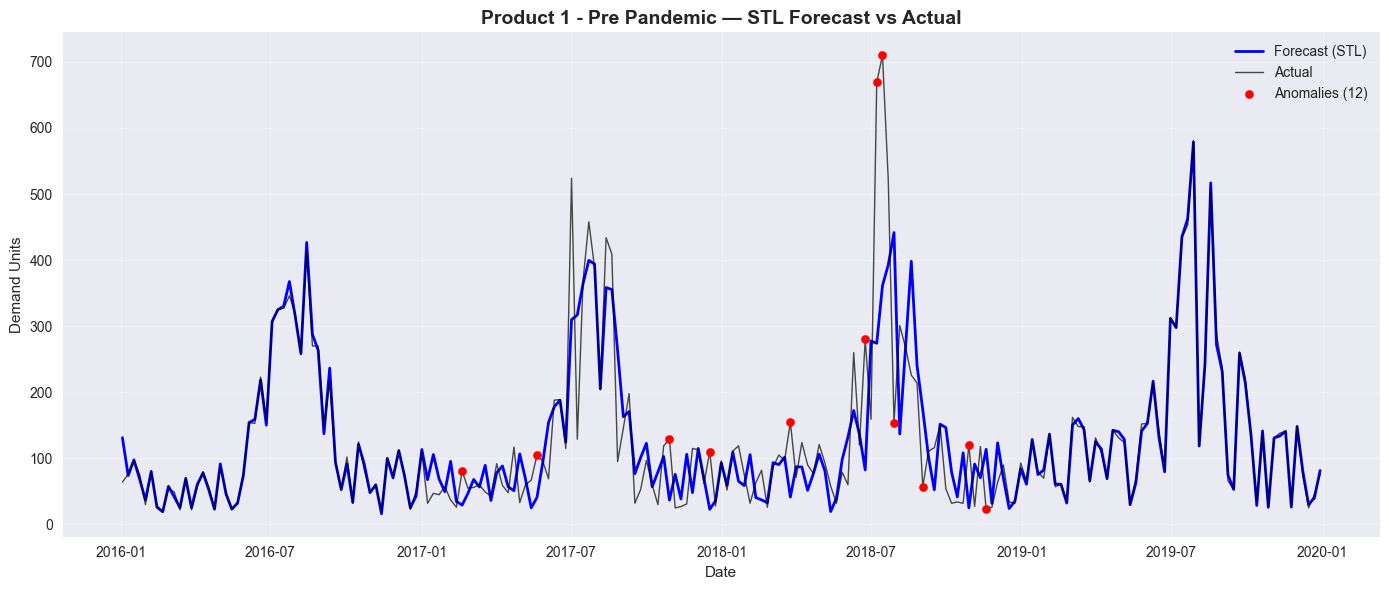

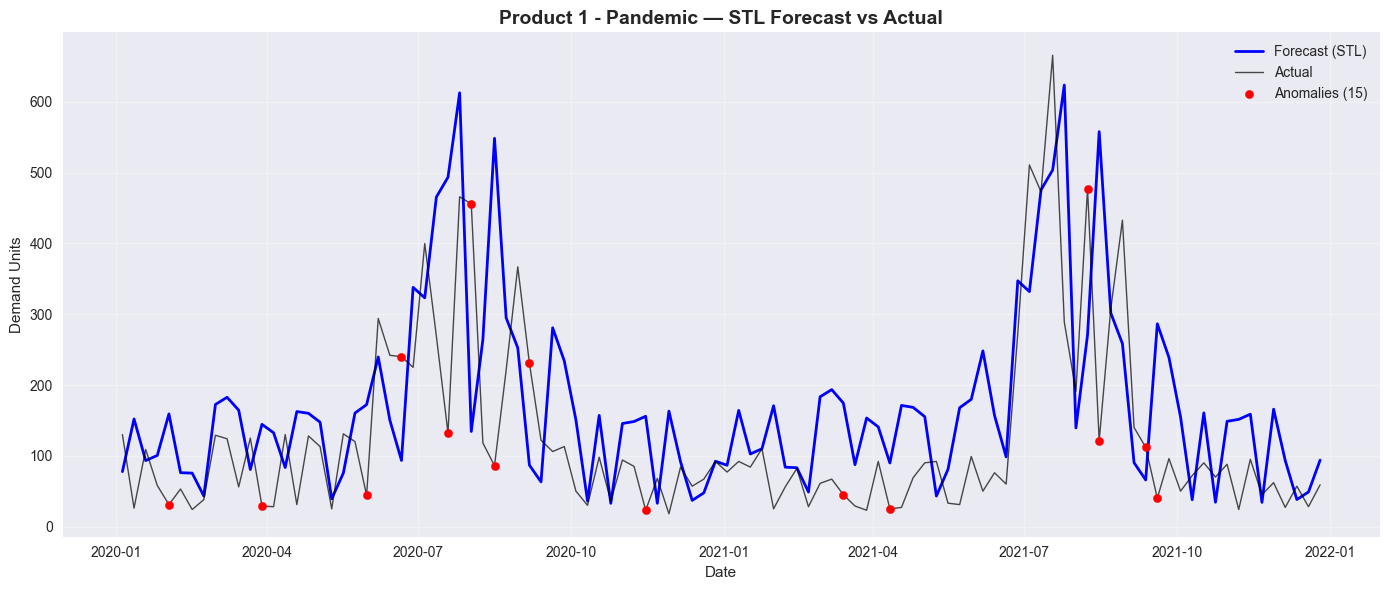

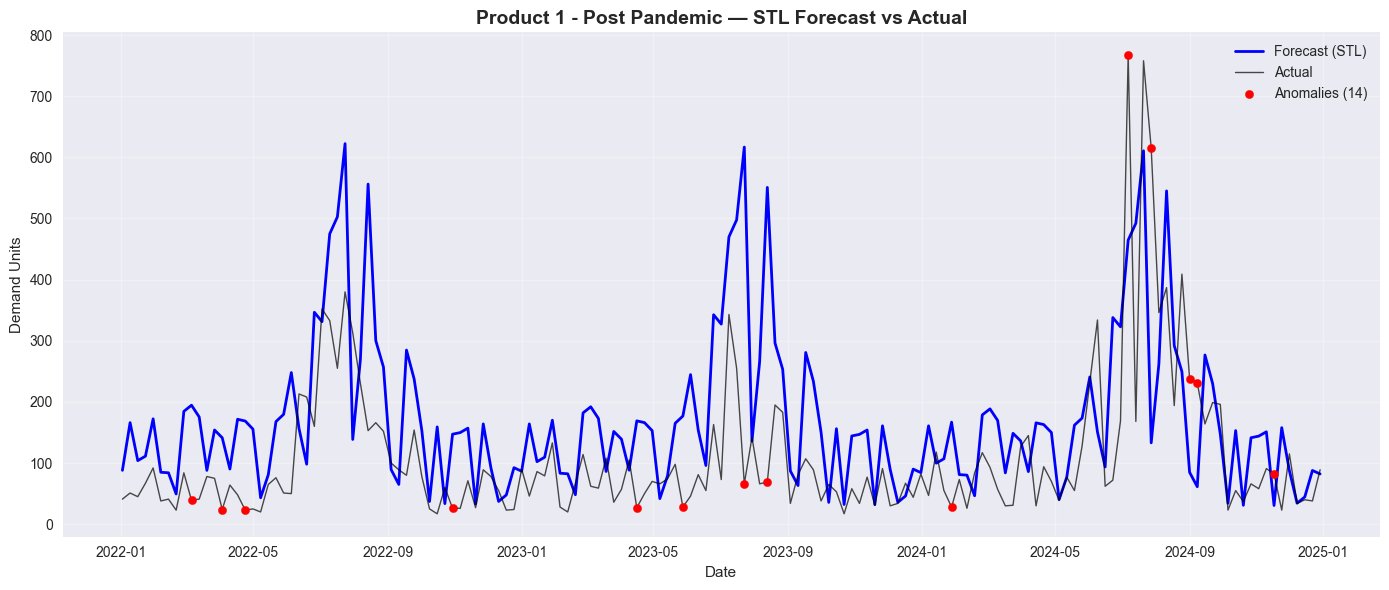

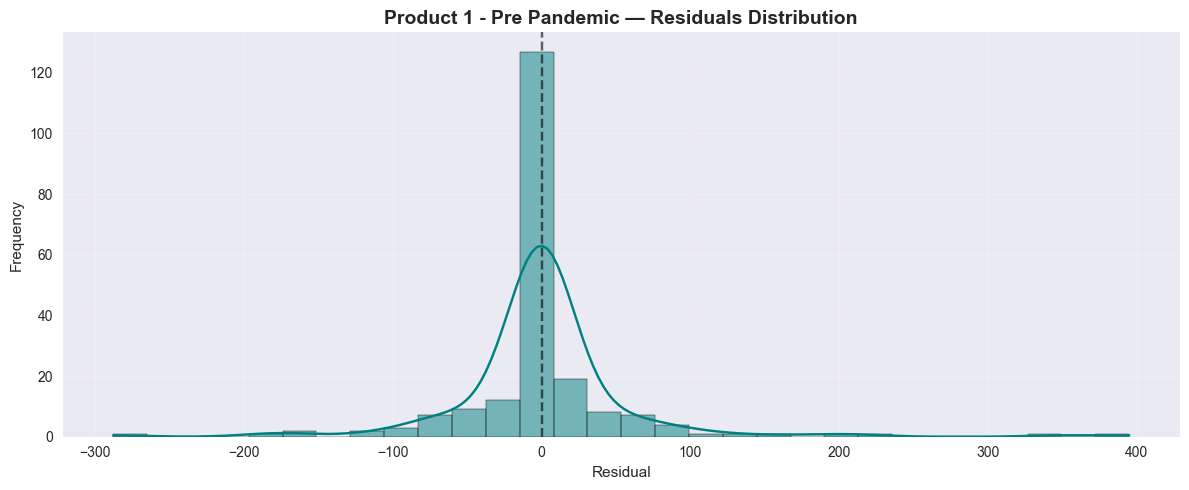

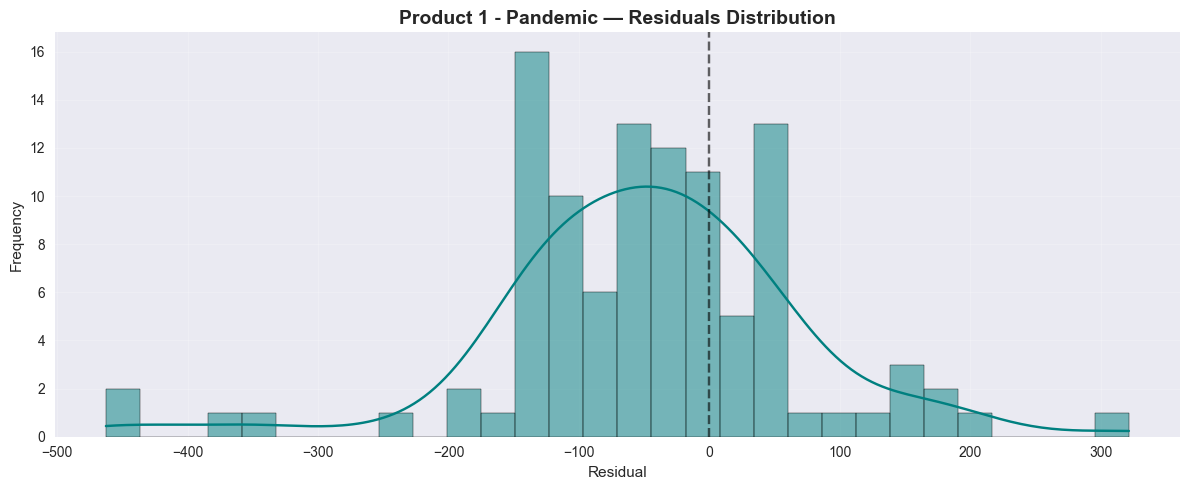

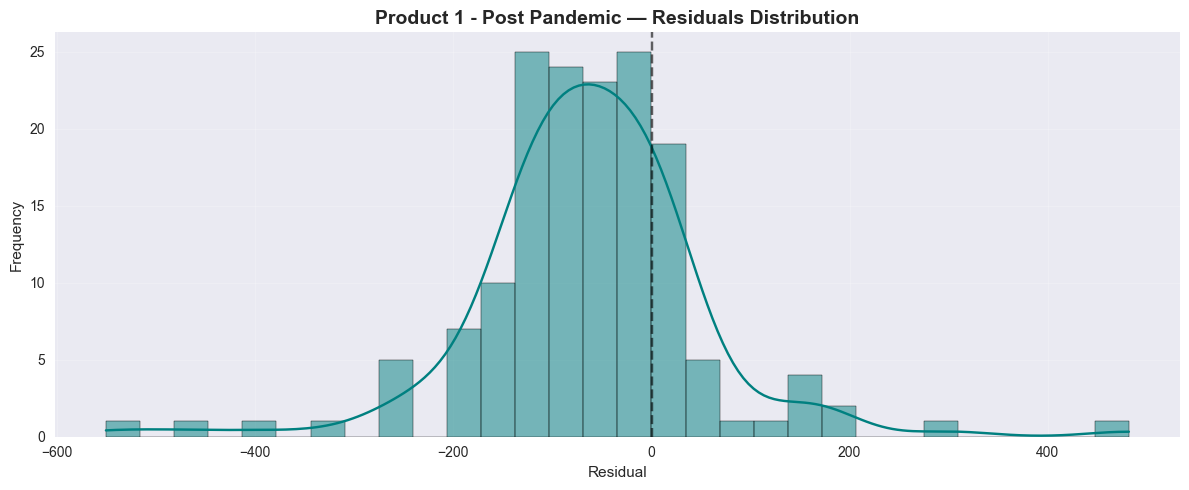

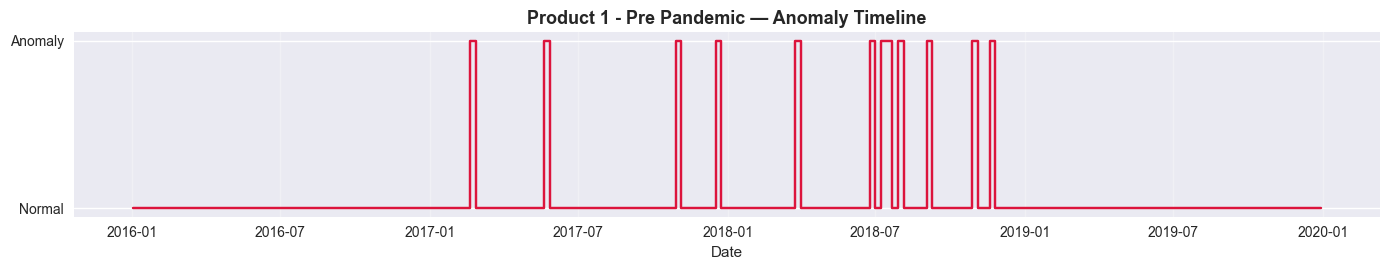

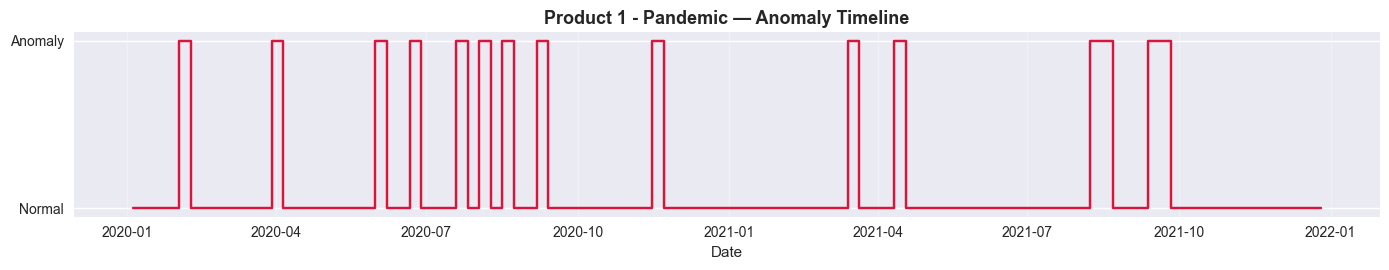

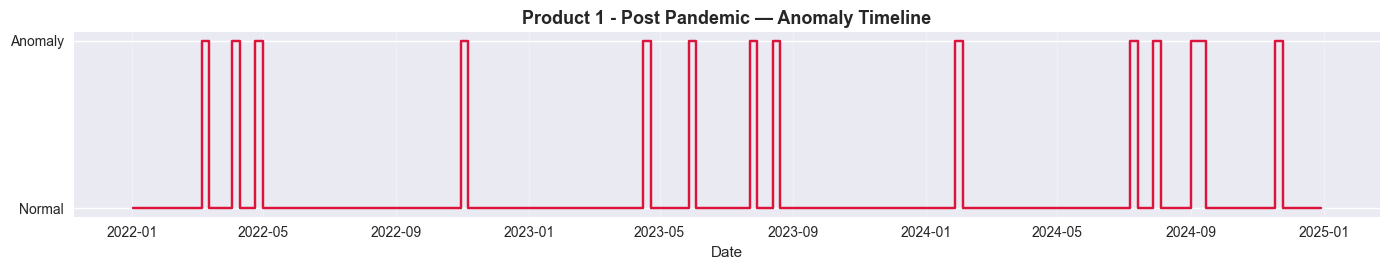

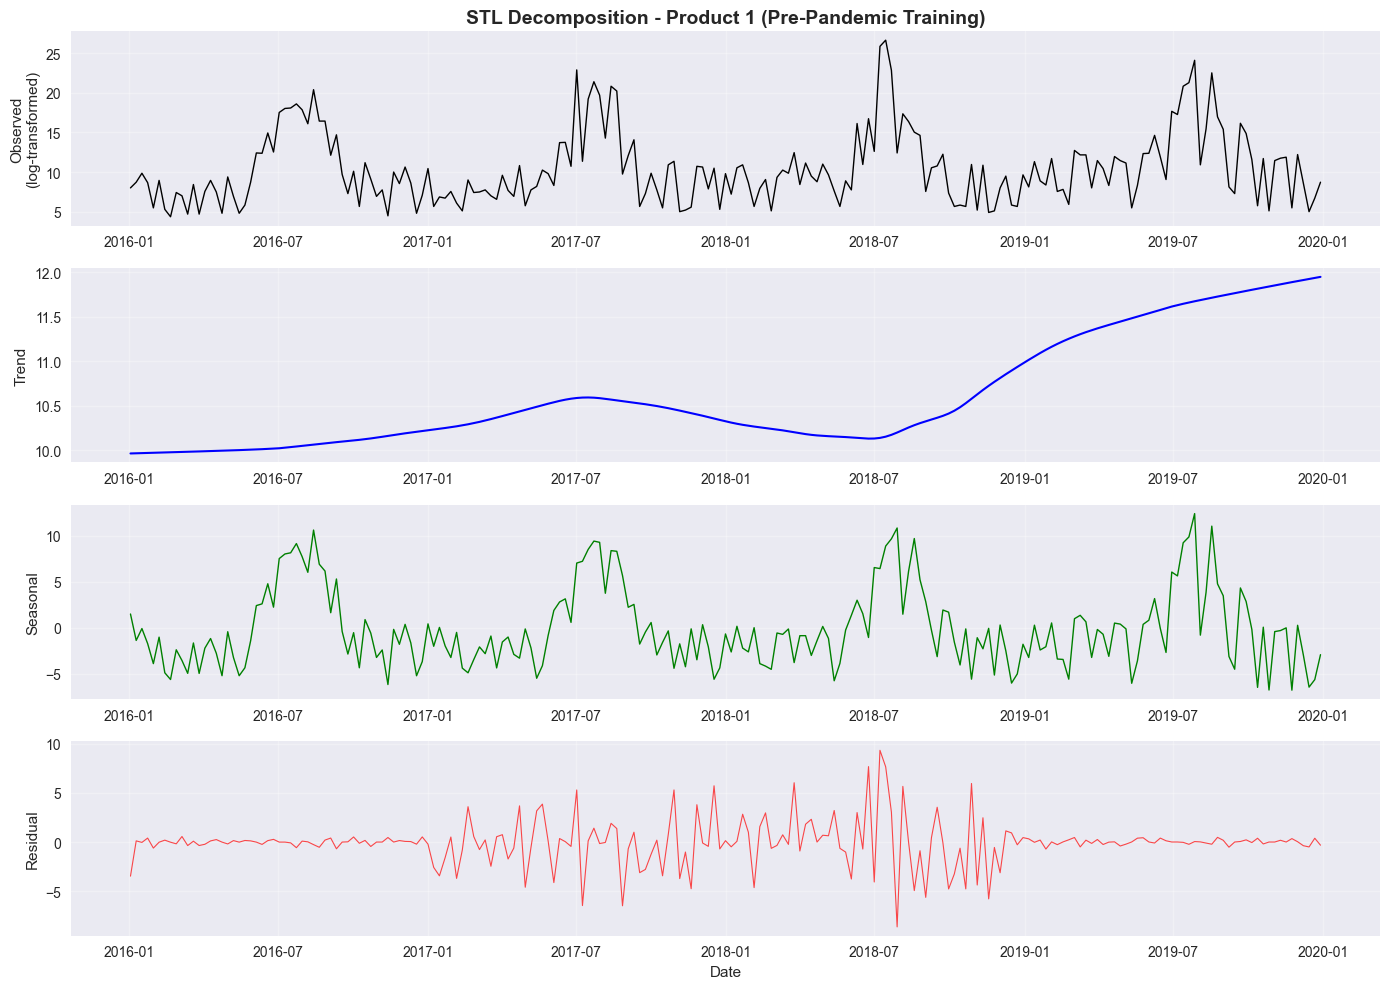

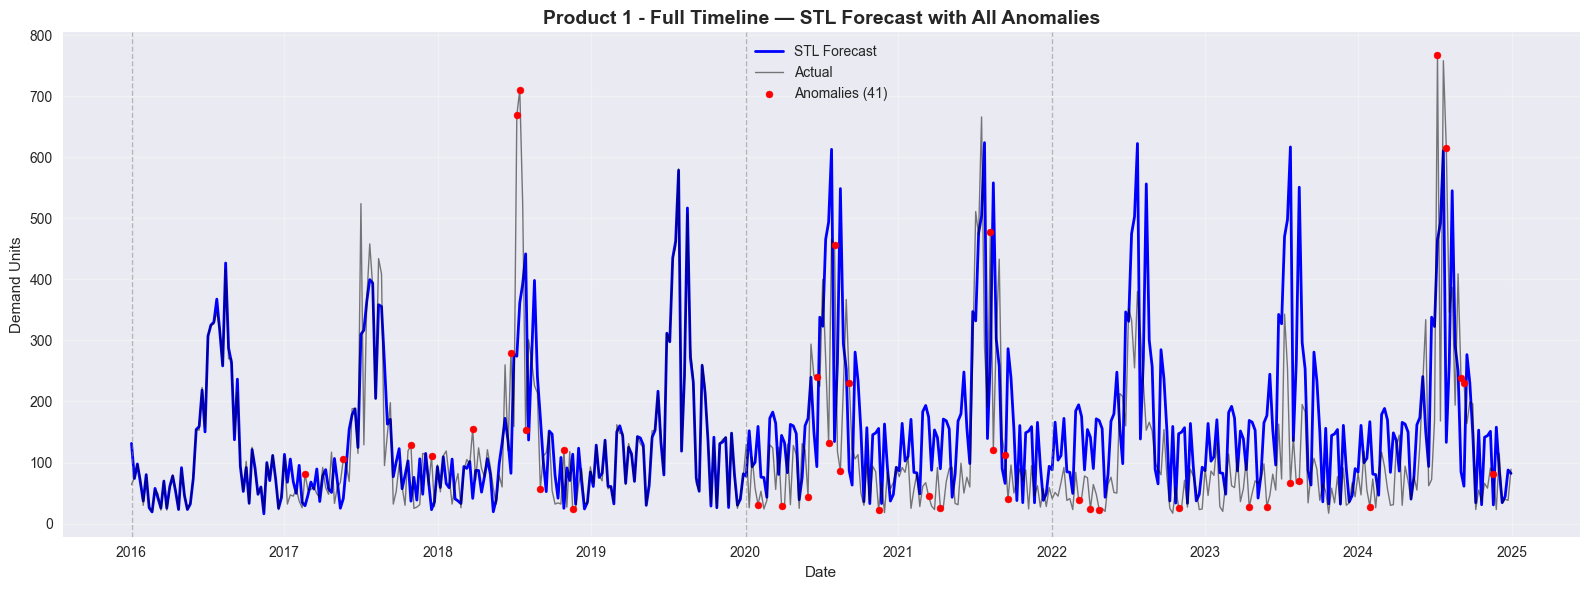

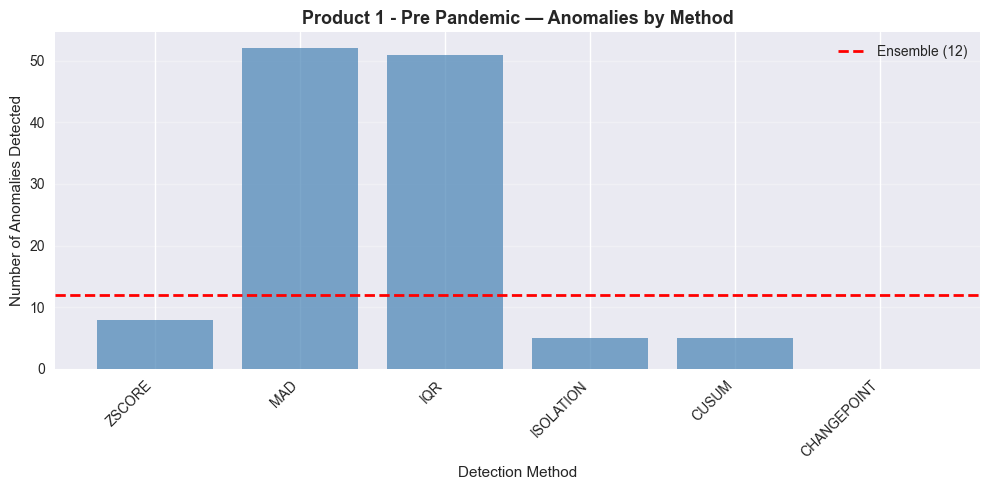

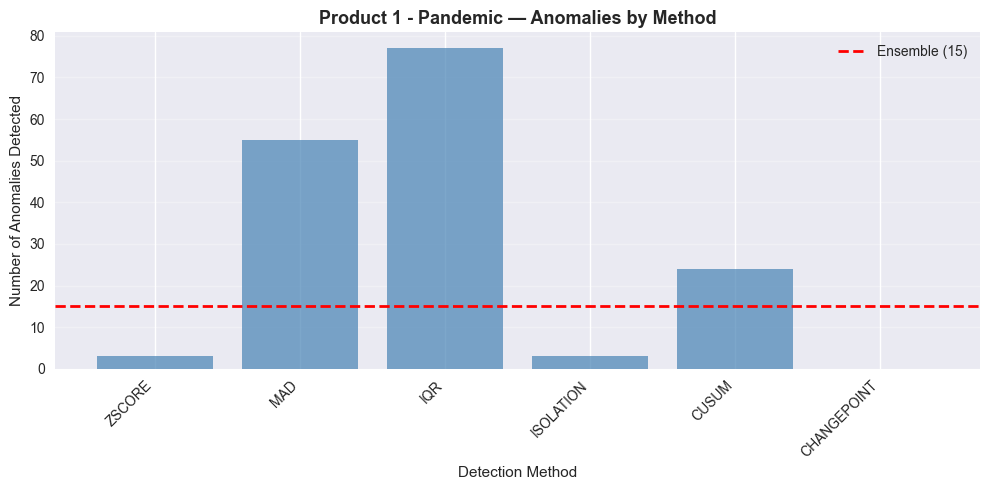

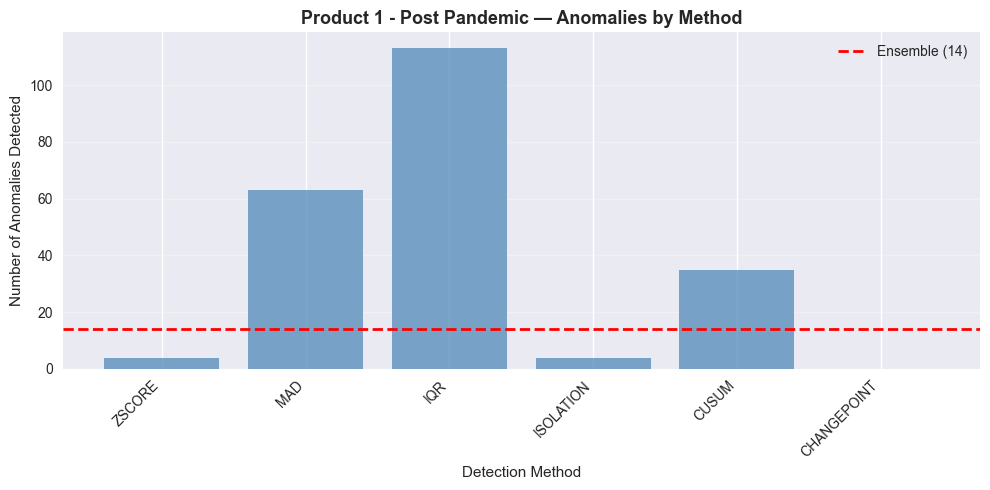

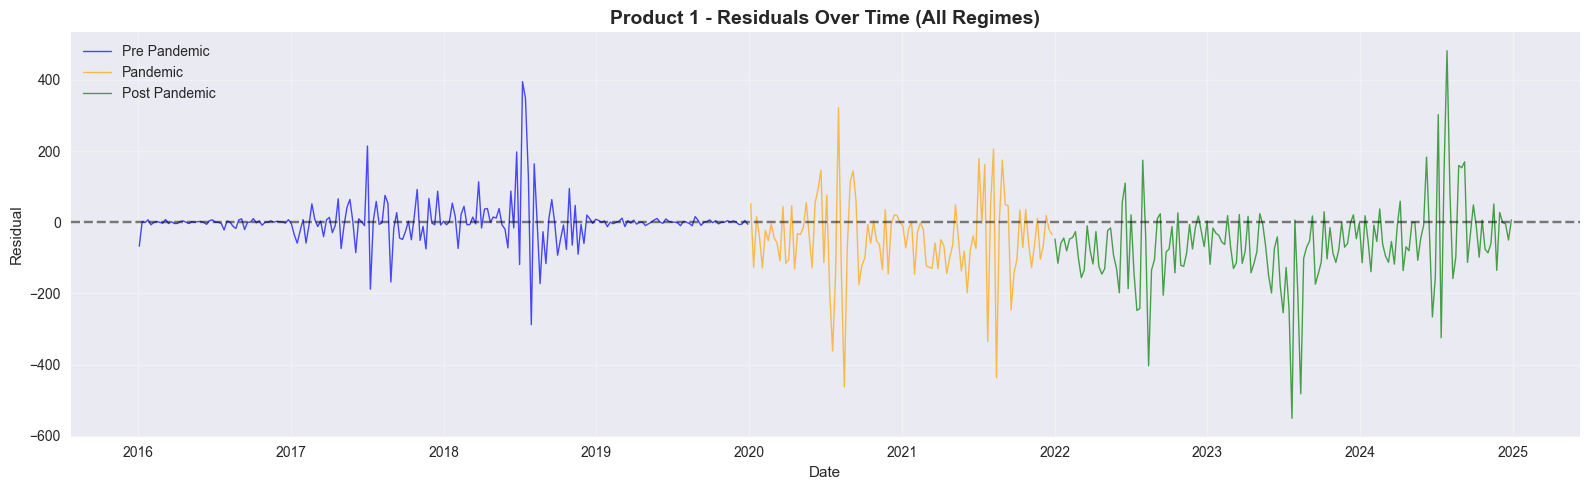

Visualization complete for 3 regimes


In [7]:
def contain_stl_product():
    forecasts = {}
    residuals = {}
    anomalies = {}
    
    if 'detector' in globals():
        try:
            forecasts = getattr(detector, 'forecasts', {}) or {}
            residuals = getattr(detector, 'residuals', {}) or {}
            anomalies = getattr(detector, 'anomalies', {}) or {}
        except Exception:
            pass
    
    return forecasts, residuals, anomalies

forecasts, residuals, anomalies = contain_stl_product()

# STL stores everything in 'all' key in forecasts, then splits by regime in residuals/anomalies
all_regimes = ['pre_pandemic', 'pandemic', 'post_pandemic']
available_regimes = [r for r in all_regimes if r in anomalies]

if len(available_regimes) == 0:
    print("No anomaly data found for Product 1. Run the STL detector first.")
else:
    # 1. Forecast vs Actual with Anomalies (by regime)
    for regime in available_regimes:
        an = anomalies.get(regime)
        
        if an is None or len(an) == 0:
            continue
        
        plt.figure(figsize=(14, 6))
        
        # Plot forecast and actual
        plt.plot(an['ds'], an['yhat'], 'b-', label='Forecast (STL)', linewidth=2)
        if 'y' in an.columns and an['y'].notna().any():
            plt.plot(an['ds'], an['y'], 'k-', alpha=0.7, label='Actual', linewidth=1)
        
        # Plot anomalies
        if 'anomaly_ensemble' in an.columns:
            points = an[an['anomaly_ensemble'] == 1]
            if len(points) > 0:
                y_col = 'y' if 'y' in an.columns else 'yhat'
                plt.scatter(points['ds'], points[y_col], color='red', s=35, zorder=5, 
                           label=f'Anomalies ({len(points)})')
        
        plt.title(f"Product 1 - {regime.replace('_',' ').title()} — STL Forecast vs Actual", 
                 fontsize=14, fontweight='bold')
        plt.xlabel('Date')
        plt.ylabel('Demand Units')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # 2. Residuals Distribution (by regime)
    for regime in available_regimes:
        rs = residuals.get(regime)
        if rs is None or len(rs) == 0 or 'residuals' not in rs.columns:
            continue
        
        plt.figure(figsize=(12, 5))
        sns.histplot(rs['residuals'].dropna(), bins=30, kde=True, color='teal')
        plt.axvline(0, color='black', linestyle='--', alpha=0.6)
        plt.title(f"Product 1 - {regime.replace('_',' ').title()} — Residuals Distribution", 
                 fontsize=14, fontweight='bold')
        plt.xlabel('Residual')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.2)
        plt.tight_layout()
        plt.show()
    
    # 3. Anomaly Timeline (by regime)
    for regime in available_regimes:
        an = anomalies.get(regime)
        if an is None or len(an) == 0 or 'anomaly_ensemble' not in an.columns:
            print(f"No anomaly data found for {regime}")
            continue
        
        series = an[['ds', 'anomaly_ensemble']].copy()
        series = series.sort_values('ds')
        
        plt.figure(figsize=(14, 2.8))
        plt.step(series['ds'], series['anomaly_ensemble'].astype(int), where='post', color='crimson')
        plt.title(f"Product 1 - {regime.replace('_',' ').title()} — Anomaly Timeline", 
                 fontsize=13, fontweight='bold')
        plt.yticks([0,1],["Normal","Anomaly"])
        plt.xlabel('Date')
        plt.grid(True, axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # 4. STL Decomposition Plot (using all data)
    if 'detector' in globals() and hasattr(detector, 'stl_results'):
        stl_obj = detector.stl_results.get('stl_obj')
        if stl_obj is not None:
            fig, axes = plt.subplots(4, 1, figsize=(14, 10))
            
            # Original (transformed)
            axes[0].plot(stl_obj.observed.index, stl_obj.observed, 'k-', linewidth=1)
            axes[0].set_ylabel('Observed\n(log-transformed)')
            axes[0].set_title('STL Decomposition - Product 1 (Pre-Pandemic Training)', 
                            fontsize=14, fontweight='bold')
            axes[0].grid(True, alpha=0.3)
            
            # Trend
            axes[1].plot(stl_obj.trend.index, stl_obj.trend, 'b-', linewidth=1.5)
            axes[1].set_ylabel('Trend')
            axes[1].grid(True, alpha=0.3)
            
            # Seasonal
            axes[2].plot(stl_obj.seasonal.index, stl_obj.seasonal, 'g-', linewidth=1)
            axes[2].set_ylabel('Seasonal')
            axes[2].grid(True, alpha=0.3)
            
            # Residual
            axes[3].plot(stl_obj.resid.index, stl_obj.resid, 'r-', linewidth=0.8, alpha=0.7)
            axes[3].set_ylabel('Residual')
            axes[3].set_xlabel('Date')
            axes[3].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
    
    # 5. Combined All-Regime View
    if 'all' in forecasts:
        all_data = forecasts['all']
        
        plt.figure(figsize=(16, 6))
        plt.plot(all_data['ds'], all_data['yhat'], 'b-', label='STL Forecast', linewidth=2)
        if 'y' in all_data.columns:
            plt.plot(all_data['ds'], all_data['y'], 'k-', alpha=0.5, label='Actual', linewidth=1)
        
        # Overlay all anomalies from all regimes
        all_anomalies = pd.concat([anomalies[r] for r in available_regimes], ignore_index=True)
        points = all_anomalies[all_anomalies['anomaly_ensemble'] == 1]
        if len(points) > 0:
            y_col = 'y' if 'y' in points.columns else 'yhat'
            plt.scatter(points['ds'], points[y_col], color='red', s=25, zorder=5,
                       label=f'Anomalies ({len(points)})')
        
        # Add regime boundaries
        regime_dates = detector.regimes if 'detector' in globals() else {}
        if regime_dates:
            for regime_name, dates in regime_dates.items():
                start = pd.to_datetime(dates['start'])
                plt.axvline(start, color='gray', linestyle='--', alpha=0.5, linewidth=1)
        
        plt.title("Product 1 - Full Timeline — STL Forecast with All Anomalies", 
                 fontsize=14, fontweight='bold')
        plt.xlabel('Date')
        plt.ylabel('Demand Units')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # 6. Anomaly Detection Methods Comparison (by regime)
    for regime in available_regimes:
        an = anomalies.get(regime)
        if an is None or len(an) == 0:
            continue
        
        method_cols = ['anomaly_zscore', 'anomaly_mad', 'anomaly_iqr', 
                      'anomaly_isolation', 'anomaly_cusum', 'anomaly_changepoint']
        available_methods = [col for col in method_cols if col in an.columns]
        
        if not available_methods:
            continue
        
        method_counts = {col.replace('anomaly_', '').upper(): an[col].sum() 
                        for col in available_methods}
        
        plt.figure(figsize=(10, 5))
        bars = plt.bar(method_counts.keys(), method_counts.values(), color='steelblue', alpha=0.7)
        plt.axhline(y=an['anomaly_ensemble'].sum(), color='red', linestyle='--', 
                   linewidth=2, label=f"Ensemble ({an['anomaly_ensemble'].sum()})")
        plt.title(f"Product 1 - {regime.replace('_',' ').title()} — Anomalies by Method", 
                 fontsize=13, fontweight='bold')
        plt.ylabel('Number of Anomalies Detected')
        plt.xlabel('Detection Method')
        plt.xticks(rotation=45, ha='right')
        plt.legend()
        plt.grid(True, axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # 7. Residual Analysis Over Time (all regimes colored)
    all_residuals = pd.concat([residuals[r].assign(regime=r) for r in available_regimes], 
                              ignore_index=True)
    
    plt.figure(figsize=(16, 5))
    colors = {'pre_pandemic': 'blue', 'pandemic': 'orange', 'post_pandemic': 'green'}
    for regime in available_regimes:
        regime_data = all_residuals[all_residuals['regime'] == regime]
        plt.plot(regime_data['ds'], regime_data['residuals'], 
                label=regime.replace('_', ' ').title(), 
                color=colors.get(regime, 'gray'), alpha=0.7, linewidth=1)
    
    plt.axhline(0, color='black', linestyle='--', alpha=0.5)
    plt.title("Product 1 - Residuals Over Time (All Regimes)", fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Residual')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print(f"Visualization complete for {len(available_regimes)} regimes")

In [9]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, Optional
from statsmodels.tsa.seasonal import STL
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
from scipy.stats import median_abs_deviation
import scipy.stats as stats
import ruptures as rpt
import traceback

plt.style.use('default')
sns.set_palette("husl")

class STLAnomalyDetector:
    """STL-based anomaly detection matching single-product implementation."""
    
    def __init__(self, seasonal_period: int = 52, seasonal_window: int = 13, 
                 trend_window: int = 53, robust: bool = True):
        self.seasonal_period = seasonal_period
        self.seasonal_window = seasonal_window if seasonal_window % 2 == 1 else seasonal_window + 1
        self.trend_window = trend_window if trend_window % 2 == 1 else trend_window + 1
        self.robust = robust
        
        # Hyperparameters matching single-product implementation
        self.ZSCORE_THRESH = 2.5
        self.MAD_THRESH = 2.5
        self.IQR_MULTIPLIER = 1.5
        self.CUSUM_K = 0.3
        self.CUSUM_H = 3.5
        self.CHANGEPOINT_PEN = 15
        self.ENSEMBLE_VOTE_THRESH = 3  # ≥3 methods for ensemble
        self.ANY_VOTE_THRESH = 2       # ≥2 methods for any_method
        self.STRICT_VOTE_THRESH = 4    # ≥4 methods for strict
        
        # Regime definitions
        self.regimes = {
            'pre_pandemic': {'start': '2016-01-03', 'end': '2019-12-29'},
            'pandemic': {'start': '2020-01-05', 'end': '2021-12-26'},
            'post_pandemic': {'start': '2022-01-02', 'end': '2024-12-29'}
        }
    
    def _resample_to_weekly(self, ts: pd.Series) -> pd.Series:
        """Resample time series to regular weekly frequency."""
        if not isinstance(ts.index, pd.DatetimeIndex):
            ts.index = pd.to_datetime(ts.index)
        
        ts = ts.sort_index()
        ts = ts[~ts.index.duplicated(keep='first')]
        
        start_date = ts.index.min()
        end_date = ts.index.max()
        weekly_dates = pd.date_range(start=start_date, end=end_date, freq='W-SUN')
        
        if len(weekly_dates) < 104:
            weekly_start = start_date - pd.Timedelta(days=start_date.weekday())
            weekly_end = end_date + pd.Timedelta(days=6-end_date.weekday())
            weekly_dates = pd.date_range(start=weekly_start, end=weekly_end, freq='W-SUN')
        
        ts_weekly = ts.reindex(weekly_dates, method='nearest', tolerance=pd.Timedelta(days=4))
        ts_weekly = ts_weekly.interpolate(method='time').fillna(method='bfill').fillna(method='ffill')
        
        return ts_weekly
    
    def fit_stl_prepandemic_only(self, ts: pd.Series) -> Dict:
        """Fit STL on pre-pandemic data only, then extrapolate."""
        # Resample to weekly
        ts_resampled = self._resample_to_weekly(ts)
        
        # Create full index
        full_index = ts_resampled.index
        
        # Extract pre-pandemic period
        pre_start = pd.to_datetime(self.regimes['pre_pandemic']['start'])
        pre_end = pd.to_datetime(self.regimes['pre_pandemic']['end'])
        pre_mask = (full_index >= pre_start) & (full_index <= pre_end)
        ts_pre = ts_resampled.loc[pre_mask]
        
        if len(ts_pre) < 104:
            raise ValueError(f"Insufficient pre-pandemic data: {len(ts_pre)} weeks")
        
        # Fill missing values (light)
        ts_pre_filled = ts_pre.fillna(method='ffill', limit=2).fillna(method='bfill', limit=2)
        if ts_pre_filled.isna().any():
            ts_pre_filled = ts_pre_filled.interpolate(method='linear')
        
        # Sqrt transform for variance stabilization
        ts_pre_trans = np.sqrt(np.maximum(ts_pre_filled, 0))
        
        # Fit STL on pre-pandemic
        stl_pre = STL(ts_pre_trans, 
                     period=self.seasonal_period,
                     seasonal=self.seasonal_window,
                     trend=self.trend_window,
                     robust=self.robust).fit()
        
        trend_pre = stl_pre.trend
        seasonal_pre = stl_pre.seasonal
        
        # Extrapolate trend with dampening
        n_total = len(full_index)
        n_pre = len(trend_pre)
        n_future = n_total - n_pre
        
        if n_future > 0:
            # Linear regression on last 52 weeks of trend
            lookback = min(52, n_pre)
            X_train = np.arange(n_pre - lookback, n_pre).reshape(-1, 1)
            y_train = trend_pre.values[-lookback:]
            lr = LinearRegression().fit(X_train, y_train)
            
            # Forecast with exponential dampening
            future_idx = np.arange(n_pre, n_total).reshape(-1, 1)
            trend_forecast = lr.predict(future_idx)
            damping_factor = np.exp(-0.01 * np.arange(n_future))
            last_trend = trend_pre.values[-1]
            trend_forecast = last_trend + (trend_forecast - last_trend) * damping_factor
            
            # Repeat seasonal pattern
            seasonal_pattern = seasonal_pre[-52:].values
            n_reps = int(np.ceil(n_future / 52))
            seasonal_forecast = np.tile(seasonal_pattern, n_reps)[:n_future]
            
            # Combine components
            trend_all = np.concatenate([trend_pre.values, trend_forecast])
            seasonal_all = np.concatenate([seasonal_pre.values, seasonal_forecast])
        else:
            trend_all = trend_pre.values
            seasonal_all = seasonal_pre.values
        
        yhat_trans = trend_all + seasonal_all
        
        # Inverse transform
        yhat = np.square(yhat_trans)
        yhat = np.maximum(yhat, 0)
        
        # Fill full series
        ts_full_filled = ts_resampled.fillna(method='ffill', limit=3).fillna(method='bfill', limit=3)
        if ts_full_filled.isna().any():
            ts_full_filled = ts_full_filled.interpolate(method='linear')
        
        # Build forecast dataframe
        forecast_df = pd.DataFrame({
            'ds': full_index,
            'yhat': yhat,
            'y': ts_full_filled.values
        })
        
        # Add confidence intervals
        pre_resid = ts_pre_filled.values - (np.square(trend_pre.values + seasonal_pre.values))
        std_resid = np.std(pre_resid)
        forecast_df['yhat_lower'] = np.maximum(forecast_df['yhat'] - 1.96 * std_resid, 0)
        forecast_df['yhat_upper'] = forecast_df['yhat'] + 1.96 * std_resid
        
        return {
            'stl_obj': stl_pre,
            'forecast': forecast_df,
            'ts_resampled': ts_resampled
        }
    
    def compute_residuals(self, forecast_df: pd.DataFrame) -> pd.DataFrame:
        """Compute residuals with robust percentage error calculation."""
        df = forecast_df.copy()
        df['residuals'] = df['y'] - df['yhat']
        df['abs_residuals'] = np.abs(df['residuals'])
        df['squared_residuals'] = df['residuals'] ** 2
        
        # Robust denominator for percentage
        pre_start = pd.to_datetime(self.regimes['pre_pandemic']['start'])
        pre_end = pd.to_datetime(self.regimes['pre_pandemic']['end'])
        pre_mask = (df['ds'] >= pre_start) & (df['ds'] <= pre_end)
        
        yhat_pre = df.loc[pre_mask, 'yhat'].abs().replace(0, np.nan).dropna()
        if len(yhat_pre) > 0:
            denom_floor = np.percentile(yhat_pre, 10)
            denom_floor = max(denom_floor, 1.0)
        else:
            denom_floor = 1.0
        
        safe_denom = np.maximum(np.abs(df['yhat']), denom_floor)
        df['resid_pct'] = 100.0 * df['residuals'] / safe_denom
        df['abs_resid_pct'] = np.abs(df['resid_pct'])
        
        return df
    
    def classify_regimes(self, dates: pd.Series) -> pd.Series:
        """Classify dates into regimes."""
        def classify_date(date):
            if pd.isna(date):
                return 'unknown'
            year = pd.to_datetime(date).year
            if year <= 2019:
                return 'pre_pandemic'
            elif year in [2020, 2021]:
                return 'pandemic'
            elif year >= 2022:
                return 'post_pandemic'
            return 'unknown'
        
        return dates.apply(classify_date)
    
    def detect_anomalies(self, residuals_df: pd.DataFrame) -> pd.DataFrame:
        """Detect anomalies using ensemble of methods with pre-pandemic baseline."""
        df = residuals_df.copy()
        
        # Get pre-pandemic baseline statistics
        regimes = self.classify_regimes(df['ds'])
        df['regime'] = regimes
        
        pre_mask = regimes == 'pre_pandemic'
        pre_resid_pct = df.loc[pre_mask, 'resid_pct'].fillna(0).to_numpy()
        
        eps = 1e-8
        baseline_std = max(pre_resid_pct.std(ddof=1), eps)
        baseline_mad = max(median_abs_deviation(pre_resid_pct, scale=1.0), eps)
        q75, q25 = np.percentile(pre_resid_pct, [75, 25])
        iqr = max(q75 - q25, eps)
        
        # Adaptive contamination for Isolation Forest
        target_fpr = 0.02
        pre_abs = np.abs(pre_resid_pct)
        thr = np.quantile(pre_abs, 1 - target_fpr)
        auto_contam = float(np.clip((pre_abs > thr).mean(), 0.005, 0.05))
        
        resid_pct = df['resid_pct'].fillna(0).to_numpy()
        residuals = df['residuals'].fillna(0).to_numpy()
        
        # 1. Z-score
        z_scores = np.abs(resid_pct / baseline_std)
        df['anomaly_zscore'] = (z_scores > self.ZSCORE_THRESH).astype(int)
        
        # 2. MAD
        mz = 0.6745 * np.abs(resid_pct - np.median(resid_pct)) / baseline_mad
        df['anomaly_mad'] = (mz > self.MAD_THRESH).astype(int)
        
        # 3. IQR
        df['anomaly_iqr'] = (
            ((resid_pct < (q25 - self.IQR_MULTIPLIER * iqr)) |
             (resid_pct > (q75 + self.IQR_MULTIPLIER * iqr)))
        ).astype(int)
        
        # 4. Isolation Forest
        iso_forest = IsolationForest(contamination=auto_contam, random_state=42)
        try:
            iso_pred = iso_forest.fit_predict(resid_pct.reshape(-1, 1))
            df['anomaly_isolation'] = (iso_pred == -1).astype(int)
        except Exception:
            df['anomaly_isolation'] = 0
        
        # 5. CUSUM
        df['anomaly_cusum'] = self._cusum_detection(residuals, baseline_std)
        
        # 6. Changepoint
        try:
            algo = rpt.Pelt(model="rbf").fit(resid_pct)
            changepoints = algo.predict(pen=self.CHANGEPOINT_PEN)
            cp_flag = np.zeros(len(resid_pct), dtype=bool)
            for cp in changepoints[:-1]:
                start_idx = max(0, cp - 1)
                end_idx = min(len(resid_pct), cp + 2)
                cp_flag[start_idx:end_idx] = True
            df['anomaly_changepoint'] = cp_flag.astype(int)
        except Exception:
            df['anomaly_changepoint'] = 0
        
        # Ensemble voting
        method_cols = ['anomaly_zscore', 'anomaly_mad', 'anomaly_iqr',
                       'anomaly_isolation', 'anomaly_cusum', 'anomaly_changepoint']
        df['vote_count'] = df[method_cols].sum(axis=1)
        
        df['anomaly_ensemble'] = (df['vote_count'] >= self.ENSEMBLE_VOTE_THRESH).astype(int)
        df['anomaly_any'] = (df['vote_count'] >= self.ANY_VOTE_THRESH).astype(int)
        df['anomaly_strict'] = (df['vote_count'] >= self.STRICT_VOTE_THRESH).astype(int)
        
        return df
    
    def _cusum_detection(self, resid: np.ndarray, sigma: float) -> np.ndarray:
        """CUSUM anomaly detection."""
        if not sigma or sigma <= 1e-8:
            return np.zeros(len(resid), dtype=int)
        
        k = self.CUSUM_K * sigma
        h = self.CUSUM_H * sigma
        Spos = np.zeros_like(resid, dtype=float)
        Sneg = np.zeros_like(resid, dtype=float)
        flags = np.zeros_like(resid, dtype=int)
        
        for i in range(1, len(resid)):
            Spos[i] = max(0.0, Spos[i-1] + resid[i] - k)
            Sneg[i] = min(0.0, Sneg[i-1] + resid[i] + k)
            if Spos[i] > h or Sneg[i] < -h:
                flags[i] = 1
                Spos[i] = 0.0
                Sneg[i] = 0.0
        
        return flags
    
    def detect_anomalies_single_product(self, product_data: pd.DataFrame, 
                                       product_id: int) -> pd.DataFrame:
        """Run complete pipeline for single product."""
        product_data_clean = product_data.copy()
        product_data_clean['week_start_date'] = pd.to_datetime(
            product_data_clean['week_start_date'])
        product_data_clean = product_data_clean.sort_values('week_start_date')
        product_data_clean = product_data_clean.drop_duplicates(subset=['week_start_date'])
        
        ts = product_data_clean.set_index('week_start_date')['demand_units']
        
        print(f"Processing Product {product_id}: {len(ts)} observations")
        print(f"  Date range: {ts.index.min()} to {ts.index.max()}")
        
        # STL fit on pre-pandemic only
        try:
            stl_result = self.fit_stl_prepandemic_only(ts)
        except Exception as e:
            print(f"  STL failed for product {product_id}: {e}")
            return pd.DataFrame()
        
        # Compute residuals
        forecast_with_resid = self.compute_residuals(stl_result['forecast'])
        
        # Detect anomalies
        results_df = self.detect_anomalies(forecast_with_resid)
        results_df['product_id'] = product_id
        
        # Calculate regime-specific MAE/RMSE
        for regime in ['pre_pandemic', 'pandemic', 'post_pandemic']:
            regime_mask = results_df['regime'] == regime
            if regime_mask.sum() > 0:
                mae = results_df.loc[regime_mask, 'abs_residuals'].mean()
                rmse = np.sqrt(results_df.loc[regime_mask, 'squared_residuals'].mean())
                maep = results_df.loc[regime_mask, 'abs_resid_pct'].mean()
                print(f"  {regime} residuals - MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAE%: {maep:.2f}%")
        
        final_count = results_df['anomaly_ensemble'].sum()
        print(f"  Detected {final_count} ensemble anomalies")
        
        return results_df

def run_stl_anomaly_detection_all_products(dataset_path: str, output_dir: str = "stl_output"):
    """Run STL anomaly detection across all products."""
    Path(output_dir).mkdir(exist_ok=True)
    
    print(f"Loading dataset: {dataset_path}")
    df = pd.read_csv(dataset_path)
    df['week_start_date'] = pd.to_datetime(df['week_start_date'])
    
    print(f"Dataset shape: {df.shape}")
    print(f"Products: {sorted(df['product_id'].unique())}")
    print(f"Date range: {df['week_start_date'].min()} to {df['week_start_date'].max()}")
    
    # Initialize detector with matching hyperparameters
    detector = STLAnomalyDetector(
        seasonal_period=52,
        seasonal_window=13,
        trend_window=53,
        robust=True
    )
    
    all_results = []
    summary_stats = []
    
    product_ids = sorted(df['product_id'].unique())
    
    for product_id in product_ids:
        print(f"\n{'='*50}")
        print(f"PROCESSING PRODUCT {product_id}")
        print(f"{'='*50}")
        
        product_data = df[df['product_id'] == product_id].copy()
        
        if len(product_data) < 104:
            print(f"  Skipping product {product_id}: insufficient data ({len(product_data)} weeks)")
            continue
        
        try:
            product_results = detector.detect_anomalies_single_product(product_data, product_id)
            
            if product_results.empty:
                continue
            
            # Save individual results
            product_output_path = Path(output_dir) / f"product_{product_id:02d}.csv"
            product_results.to_csv(product_output_path, index=False)
            print(f"  Saved: {product_output_path}")
            
            all_results.append(product_results)
            
            # Calculate summary by regime
            regime_stats = product_results.groupby('regime').agg({
                'anomaly_ensemble': ['count', 'sum']
            })
            regime_stats.columns = ['total_weeks', 'anomaly_count']
            regime_stats['anomaly_rate'] = (
                regime_stats['anomaly_count'] / regime_stats['total_weeks'] * 100
            ).round(2)
            
            for regime in regime_stats.index:
                summary_stats.append({
                    'product_id': product_id,
                    'regime': regime,
                    'total_weeks': regime_stats.loc[regime, 'total_weeks'],
                    'anomaly_count': regime_stats.loc[regime, 'anomaly_count'],
                    'anomaly_rate_pct': regime_stats.loc[regime, 'anomaly_rate']
                })
        
        except Exception as e:
            print(f"  ERROR processing product {product_id}: {str(e)}")
            traceback.print_exc()
            continue
    
    # Save summary
    if summary_stats:
        summary_df = pd.DataFrame(summary_stats)
        summary_pivot = summary_df.pivot(
            index='product_id',
            columns='regime',
            values=['anomaly_count', 'anomaly_rate_pct']
        )
        
        summary_output_path = Path(output_dir) / "anomaly_summary.csv"
        summary_pivot.to_csv(summary_output_path)
        print(f"\nSaved summary: {summary_output_path}")
        
        print(f"\n{'='*60}")
        print("ANOMALY DETECTION SUMMARY")
        print(f"{'='*60}")
        print(summary_pivot.round(2))
    
    # Combine all results
    if all_results:
        combined_df = pd.concat(all_results, ignore_index=True)
        combined_output_path = Path(output_dir) / "all_products_anomalies.csv"
        combined_df.to_csv(combined_output_path, index=False)
        print(f"\nSaved combined results: {combined_output_path}")
        
        return combined_df, summary_df if summary_stats else None
    else:
        print("\nNo results generated!")
        return None, None

# Main execution
if __name__ == "__main__":
    DATASET_PATH = "/Users/camilla/Desktop/Term2/Dissertation/UK20162023_modified.csv"
    OUTPUT_DIR = "stl_anomaly_results_v2"
    
    print("Starting STL Anomaly Detection Analysis...")
    print(f"Dataset: {DATASET_PATH}")
    print(f"Output Directory: {OUTPUT_DIR}\n")
    
    combined_results, summary_results = run_stl_anomaly_detection_all_products(
        dataset_path=DATASET_PATH,
        output_dir=OUTPUT_DIR
    )
    
    print("\nAnalysis Complete!")

Starting STL Anomaly Detection Analysis...
Dataset: /Users/camilla/Desktop/Term2/Dissertation/UK20162023_modified.csv
Output Directory: stl_anomaly_results_v2

Loading dataset: /Users/camilla/Desktop/Term2/Dissertation/UK20162023_modified.csv
Dataset shape: (27017, 19)
Products: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
Date range: 2016-01-03 00:00:00 to 2024-12-29 00:00:00

PROCESSING PRODUCT 1
Processing Product 1: 470 observations
  Date range: 2016-01-03 00:00:00 to 2024-12-29 00:00:00
  pre_pandemic residuals - MAE: 4.42, RMSE: 10.54, MAE%: 8.96%
  pandemic residuals - MAE: 17.19, RMSE: 26.55, MAE%: 27.06%
  post_pandemic residuals - MAE: 23.85, RMSE: 34.99, MAE%: 35.46%
  Detected 124 ensemble anomalies
  Saved: stl_anomaly_results_v2/product_01.csv

PROCESSING PRODUCT 2
Processing Product 2: 470 observations
  Date range: 2016-01-03 00:00:00 to 2024-12-29 00:00:00
  pre_pandemic residuals - MAE: 3.50, RMSE: 6.95, MAE%: 9.66%
  pandemic r